In [1]:
import matplotlib
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
import gseapy as gp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn import metrics

from cmapPy.pandasGEXpress.parse import parse
from scipy import stats
from pandas import DataFrame as df
from matplotlib import pyplot as plt
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Global Path

In [2]:
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/GSEA/'

In [3]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'

# Data

In [4]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

,Official NCBI gene symbol
Official NCBI gene id,
5720,PSME1
7416,VDAC1
55847,CISD1
10174,SORBS3
25803,SPDEF
...,...
5137,PDE1C
51233,DRICH1
4340,MOG


In [5]:
skcm_sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/SKCM/skcm_2020_tash_sig_info.csv',
                            header=0, index_col=0, sep=',')

In [6]:
# compound perturbations
## read original lv5 signature matrix
skcm_trt_cp_original = pd.read_csv(data_home + '/CMAP2020_Cancer/SKCM/CMAP2020_lv5_trt_cp_merged.csv',
                                   header=0, index_col=0, sep=',')
skcm_trt_cp_original.index = skcm_trt_cp_original.index.astype(int)
skcm_trt_cp_original = skcm_trt_cp_original[skcm_trt_cp_original.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])

In [7]:
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()
compound_info

,pert_id,target,moa,canonical_smiles,inchi_key,compound_aliases
cmap_name,,,,,,
1-EBIO,BRD-K70586315,NaN,NaN,CCn1c2ccccc2[nH]c1=O,CXUCKELNYMZTRT-UHFFFAOYSA-N,NaN
1-HYDROXYANTHRAQUINONE,BRD-K62620932,NaN,NaN,NaN,NaN,NaN
1-HYDROXYPHENAZINE,BRD-K66151076,NaN,NaN,NaN,NaN,NaN
1-NAPHTHYLAMINE,BRD-K05741221,NaN,NaN,NaN,NaN,NaN
1-NITRONAPHTHALENE,BRD-K72839221,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
zolpidem,BRD-K44876623,GABRA1,Benzodiazepine receptor agonist,CN(C)C(=O)Cc1c(nc2ccc(C)cn12)-c1ccc(C)cc1,ZAFYATHCZYHLPB-UHFFFAOYSA-N,NaN
zonisamide,BRD-A28095882,SCN11A,Sodium channel blocker,CN1C2CCC1CC(C2)OC(c3ccccc3)c4ccccc4N,KZFDKINRISJFCO-UHFFFAOYSA-N,NaN
zopiclone,BRD-A34309505,GABRA1,GABA receptor agonist,CN1CCN(CC1)C(=O)OC2N(C(=O)c3nccnc23)c4ccc(Cl)cn4,GBBSUAFBMRNDJC-UHFFFAOYSA-N,NaN


# Shift ability 

In [8]:
def pre_rank_merge(metric, path):
    tmp_collect = os.listdir(path)
    tmp_metric_collect = [i for i in tmp_collect if i.split('_')[2] == metric]
    tmp_results = []
    for p in tmp_metric_collect:
        tmp_r = pd.read_csv(path + '/' + p, header=0, index_col=0, sep=',')
        tmp_results.append(tmp_r)
    merged_results = pd.concat(tmp_results, axis=0)
    return merged_results

In [9]:
# merge es for compounds
merged_es_compound = pre_rank_merge(metric='es', path=gsea_home + 'SKCM_v2/compound_all_results')

merged_es_compound['shift_ability'] = merged_es_compound['NREC_profile'] - merged_es_compound['REC_profile']

In [28]:
# merge nes for compounds
merged_nes_compound = pre_rank_merge(metric='nes', path=gsea_home + 'SKCM_v2/compound_all_results')

merged_nes_compound['shift_ability'] = merged_nes_compound['NREC_profile'] - merged_nes_compound['REC_profile']

In [83]:
# PAK4 inhibitor selected
pak4_selected = ['MOAR004_A375_24H:A18', 'LJP009_A375_24H:D02', 'MOAR004_A375_24H:A17', 'REP.A014_A375_24H:K13']

In [30]:
merged_es_compound

,NREC_profile,REC_profile,cmap_name,shift_ability
PBIOA014_A375_24H:J20,-0.488382,0.426900,PD-0325901,-0.915283
PBIOA014_A375_24H:J19,-0.488156,0.433945,PD-0325901,-0.922101
PBIOA014_A375_24H:J23,-0.487444,0.399520,PD-0325901,-0.886964
PBIOA014_A375_24H:J24,-0.487263,0.434500,PD-0325901,-0.921763
PBIOA015_A375_24H:M01,-0.485613,0.380741,vemurafenib,-0.866354
...,...,...,...,...
REP.A004_A375_24H:I20,0.285440,-0.291495,CYT-997,0.576935
REP.A003_A375_24H:H13,0.289184,-0.255160,tivantinib,0.544344
REP.A009_A375_24H:F19,0.300381,-0.251986,KX-2391,0.552367
REP.A004_A375_24H:I22,0.317422,-0.268329,CYT-997,0.585751


In [31]:
merged_nes_compound

,NREC_profile,REC_profile,cmap_name,shift_ability
PBIOA018_A375_24H:A23,-2.955735,1.619200,trametinib,-4.574935
PBIOA018_A375_24H:O12,-2.885941,1.763821,doxorubicin,-4.649762
PBIOA020_A375_24H:P01,-2.821709,1.776329,NVP-TAE684,-4.598038
PBIOA018_A375_24H:A19,-2.820303,1.864846,trametinib,-4.685148
PBIOA019_A375_24H:M01,-2.812137,1.655224,dabrafenib,-4.467361
...,...,...,...,...
REP.A005_A375_24H:K09,inf,1.319384,MG-132,inf
REP.A005_A375_24H:K10,inf,1.080053,MG-132,inf
REP.A005_A375_24H:K11,inf,1.268314,MG-132,inf
REP.A005_A375_24H:C19,inf,1.156689,bortezomib,inf


# All PAK inhibitors

In [12]:
compound_info[compound_info['target'] == 'PAK4']

,pert_id,target,moa,canonical_smiles,inchi_key,compound_aliases
cmap_name,,,,,,
PF-03758309,BRD-K37764012,PAK4,P21 activated kinase inhibitor,CN(C)C[C@@H](NC(=O)N1Cc2c(Nc3nc(C)nc4ccsc34)n[...,AYCPARAPKDAOEN-LJQANCHMSA-N,NaN


In [13]:
compound_info[compound_info['moa'] == 'P21 activated kinase inhibitor']

,pert_id,target,moa,canonical_smiles,inchi_key,compound_aliases
cmap_name,,,,,,
PF-03758309,BRD-K37764012,PAK4,P21 activated kinase inhibitor,CN(C)C[C@@H](NC(=O)N1Cc2c(Nc3nc(C)nc4ccsc34)n[...,AYCPARAPKDAOEN-LJQANCHMSA-N,NaN


In [14]:
pak4_all = skcm_sig_info[skcm_sig_info['cmap_name'] == 'PF-03758309']

In [15]:
pak4_all

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
sig_id,,,,,,,,,,,,,,,,,,,,,
LJP009_A375_24H:D02,b20,3.330,3.330000,uM,3.33 uM,24 h,24.0,h,A375,BRD-K37764012,...,A375,D02,LJP009_A375_24H_X1_B20|LJP009_A375_24H_X3_B20,LJP009_A375_24H_X1_B20:D02|LJP009_A375_24H_X3_...,NaN,LJP,PF-03758309,0,1.0,0.0
LJP009_A375_24H:D03,b20,1.110,1.110000,uM,1.11 uM,24 h,24.0,h,A375,BRD-K37764012,...,A375,D03,LJP009_A375_24H_X1_B20|LJP009_A375_24H_X3_B20,LJP009_A375_24H_X1_B20:D03|LJP009_A375_24H_X3_...,NaN,LJP,PF-03758309,0,1.0,0.0
REP.A014_A375_24H:K15,b23,1.110,1.111110,uM,1.11 uM,24 h,24.0,h,A375,BRD-K37764012,...,A375,K15,REP.A014_A375_24H_X1_B23|REP.A014_A375_24H_X3_B23,REP.A014_A375_24H_X1_B23:K15|REP.A014_A375_24H...,NaN,REP,PF-03758309,0,1.0,0.0
REP.A014_A375_24H:K17,b23,0.125,0.123457,uM,0.125 uM,24 h,24.0,h,A375,BRD-K37764012,...,A375,K17,REP.A014_A375_24H_X1_B23|REP.A014_A375_24H_X3_B23,REP.A014_A375_24H_X1_B23:K17|REP.A014_A375_24H...,NaN,REP,PF-03758309,0,1.0,0.0
REP.B014_A375_24H:K14,b23,0.740,0.769231,uM,0.74 uM,24 h,24.0,h,A375,BRD-K37764012,...,A375,K14,REP.B014_A375_24H_X1_B23|REP.B014_A375_24H_X2_B23,REP.B014_A375_24H_X1_B23:K14|REP.B014_A375_24H...,NaN,REP,PF-03758309,0,1.0,0.0
REP.B014_A375_24H:K15,b23,0.250,0.256410,uM,0.25 uM,24 h,24.0,h,A375,BRD-K37764012,...,A375,K15,REP.B014_A375_24H_X1_B23|REP.B014_A375_24H_X2_B23,REP.B014_A375_24H_X1_B23:K15|REP.B014_A375_24H...,NaN,REP,PF-03758309,0,1.0,0.0
REP.A014_A375_24H:K14,b23,3.330,3.333330,uM,3.33 uM,24 h,24.0,h,A375,BRD-K37764012,...,A375,K14,REP.A014_A375_24H_X1_B23|REP.A014_A375_24H_X3_B23,REP.A014_A375_24H_X1_B23:K14|REP.A014_A375_24H...,NaN,REP,PF-03758309,0,1.0,0.0
REP.A014_A375_24H:K16,b23,0.370,0.370370,uM,0.37 uM,24 h,24.0,h,A375,BRD-K37764012,...,A375,K16,REP.A014_A375_24H_X1_B23|REP.A014_A375_24H_X3_B23,REP.A014_A375_24H_X1_B23:K16|REP.A014_A375_24H...,NaN,REP,PF-03758309,0,1.0,0.0
REP.A014_A375_24H:K13,b23,10.000,10.000000,uM,10 uM,24 h,24.0,h,A375,BRD-K37764012,...,A375,K13,REP.A014_A375_24H_X1_B23|REP.A014_A375_24H_X3_B23,REP.A014_A375_24H_X1_B23:K13|REP.A014_A375_24H...,NaN,REP,PF-03758309,0,1.0,0.0


In [17]:
pak4_tiec = skcm_trt_cp_original[pak4_all.index]

# Immune signatures genes and shifting genes

In [26]:
# read NREC and REC gene profiles
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    gene_NREC = f.readline().rstrip().split('\t')[2:]
    gene_REC = f.readline().rstrip().split('\t')[2:]

In [32]:
# read immune signatures
immune_sig = {}
with open(gsea_home + '/gene_sets/WolfEtAl_71_Symbols.gmt', 'r') as f:
    for lines in f:
        immune_sig[lines.rstrip().split('\t')[0]] = lines.rstrip().split('\t')[2:]

In [50]:
# read pathway
immune_class = pd.read_csv(data_home + 'immuneSig/signature_class.csv', header=0, index_col=0, sep=',')
print(immune_class.head())

                                class
signatures                           
MHC1_21978456    Antigen Presentation
MHC2_21978456    Antigen Presentation
MHC.I_19272155   Antigen Presentation
MHC.II_19272155  Antigen Presentation
PD1_data                  Check Point


In [33]:
immune_sig.keys()

dict_keys(['IR7_score', 'Buck14_score', 'ICS5_score', 'LIexpression_score', 'Chemokine12_score', 'NHI_5gene_score', 'CD68', 'CD8A', 'CD8_CD68_ratio', 'PD1_data', 'PDL1_data', 'PD1_PDL1_score', 'CTLA4_data', 'Bcell_mg_IGJ', 'Bcell_receptors_score', 'STAT1_score', 'CSF1_response', 'Module3_IFN_score', 'Module4_TcellBcell_score', 'Module5_TcellBcell_score', 'Module11_Prolif_score', 'TAMsurr_score', 'TcClassII_score', 'TAMsurr_TcClassII_ratio', 'IL12_score_21050467', 'IL4_score_21050467', 'IL2_score_21050467', 'IL13_score_21050467', 'IFNG_score_21050467', 'TGFB_score_21050467', 'TREM1_data', 'DAP12_data', 'Immune_NSCLC_score', 'Tcell_receptors_score', 'CHANG_CORE_SERUM_RESPONSE_UP', 'CSR_Activated_15701700', 'GP2_ImmuneTcellBcell_score', 'GP11_Immune_IFN', 'KEGG_HEMATOPOIETIC_CELL_LINEAGE', 'REACTOME_SIGNALING_IN_IMMUNE_SYSTEM', 'ZHANG_INTERFERON_RESPONSE', 'IgG_19272155', 'Interferon_19272155', 'LCK_19272155', 'MHC.I_19272155', 'MHC.II_19272155', 'STAT1_19272155', 'Troester_WoundSig_19887

In [115]:
immune_nes = pd.read_csv(gsea_home + 'SKCM_v2/high_conf_results/immune_nes.csv', sep=',', header=0, index_col=0)

In [116]:
pak4_immune_nes = immune_nes[immune_nes.index.isin(pak4_selected)]
pak4_immune_nes['dose'] = skcm_sig_info['nearest_dose']
pak4_immune_nes

<ipython-input-116-41c121ded237>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pak4_immune_nes['dose'] = skcm_sig_info['nearest_dose']


,CHANG_CORE_SERUM_RESPONSE_UP,Module11_Prolif_score,CSR_Activated_15701700,CD8_PCA_16704732,IL12_score_21050467,GRANS_PCA_16704732,ICS5_score,IR7_score,STAT1_19272155,Tcell_21978456,...,Module4_TcellBcell_score,Interferon_Cluster_21214954,Minterferon_Cluster_21214954,Module3_IFN_score,IGG_Cluster_21214954,Tcell_receptors_score,CD8_CD68_ratio,CD68,cmap_name,dose
LJP009_A375_24H:D02,-3.631196,-4.106321,-2.515089,0.758427,1.234288,1.018074,1.081080,0.911753,1.537164,0.854083,...,1.033063,1.402397,1.574892,1.870305,1.339117,0.917671,0.888151,NaN,PF-03758309,3.33
MOAR004_A375_24H:A17,-2.326565,-3.483330,-1.665329,0.854376,-1.019551,1.395360,1.195489,-0.470972,1.007763,-1.213551,...,-0.998063,1.492916,0.987532,1.963222,-0.588939,-1.248218,-0.582107,NaN,PF-03758309,3.33
MOAR004_A375_24H:A18,-2.205803,-3.182970,-1.721456,1.866021,0.840765,1.843519,1.220955,0.550338,1.301215,-0.892497,...,1.331152,1.385649,1.576315,2.012284,0.727746,-0.805835,0.927470,NaN,PF-03758309,1.11
REP.A014_A375_24H:K13,-2.753504,-3.829696,-1.973408,1.279035,0.834941,1.245616,0.944909,0.742158,0.655384,0.891125,...,1.168331,-0.807822,0.550554,0.660140,0.865226,-0.681256,1.223818,NaN,PF-03758309,10.00


In [117]:
tmp_pak4_dose = skcm_sig_info[skcm_sig_info.index.isin(pak4_selected)][['nearest_dose', 'pert_time', 'cell_mfc_name']]

In [118]:
dependence_pak4 = df(index=['pert_dose'])
for c in pak4_immune_nes.columns:
    if c != 'cmap_name':
        tmp_a375 = tmp_pak4_dose[tmp_pak4_dose['cell_mfc_name'] == 'A375'].index
        dependence_pak4.at[c, 'pert_dose'] = stats.spearmanr(pak4_immune_nes.loc[tmp_a375, c], tmp_pak4_dose.loc[tmp_a375, 'nearest_dose'])[0]
dependence_pak4 = dependence_pak4.dropna(axis=0, how='all')
dependence_pak4['immune_class'] = immune_class['class']

In [171]:
top_im_pathways = dependence_pak4.sort_values(by='pert_dose', ascending=True)[:30]
top_im_pathways

,pert_dose,immune_class
IL2_score_21050467,-0.948683,Cytokine
IFNG_score_21050467,-0.948683,IFN Signaling
IL13_score_21050467,-0.948683,Cytokine
TGFB_score_21050467,-0.948683,Cytokine
ICS5_score,-0.948683,Other
IL4_score_21050467,-0.948683,Cytokine
Minterferon_Cluster_21214954,-0.948683,IFN Signaling
Module3_IFN_score,-0.948683,IFN Signaling
Interferon_19272155,-0.632456,IFN Signaling
LCK_19272155,-0.632456,Leukocyte


In [172]:
top_im_genes = []
for g in top_im_pathways.index:
    top_im_genes.extend(immune_sig[g])
top_im_genes = list(set(top_im_genes))
print(len(top_im_genes))

1954


# immune gene expression in PAK4 inhibitor perturbations

In [173]:
pak4_tiec_im = pak4_tiec[pak4_tiec.index.isin(top_im_genes)]

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


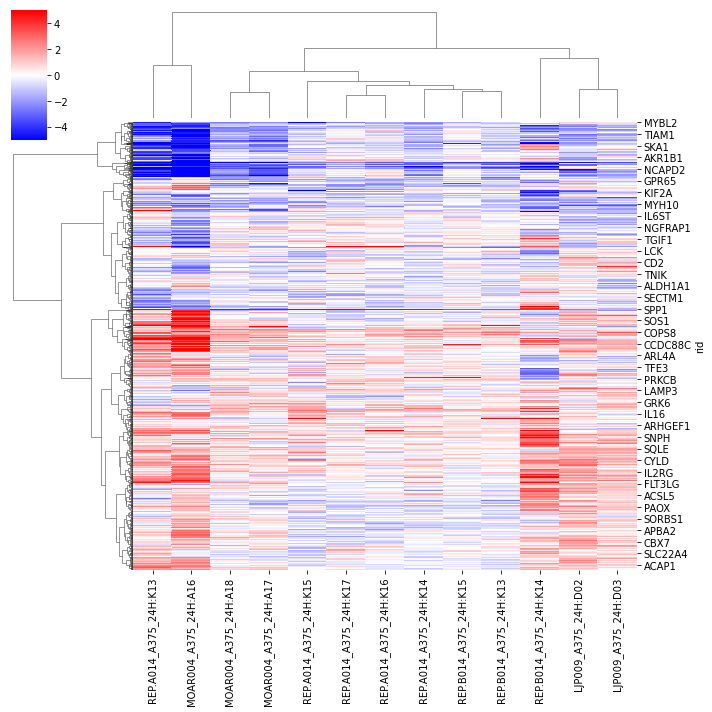

In [174]:
sns.clustermap(pak4_tiec_im,
               vmin=-5, vmax=5,
               cmap='bwr', method='ward')

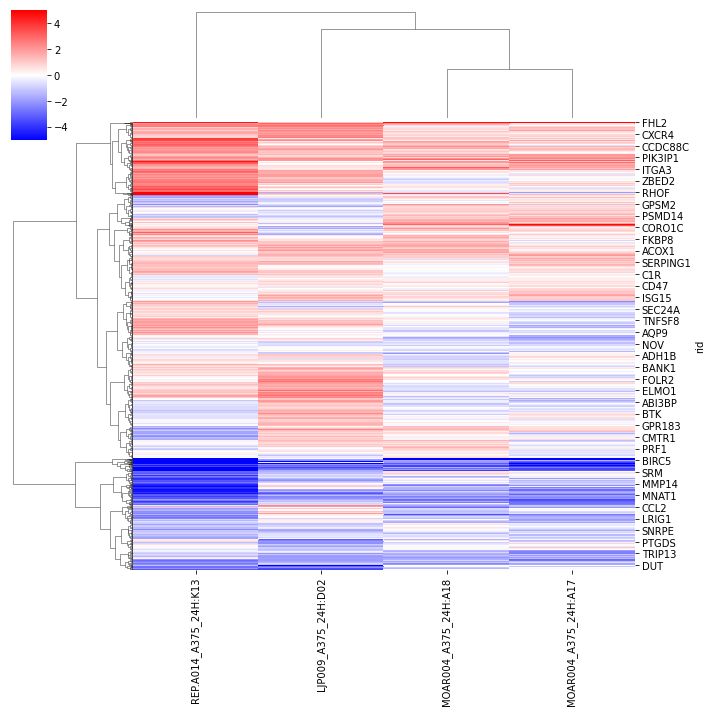

In [175]:
sns.clustermap(pak4_tiec_im[pak4_selected],
               vmin=-5, vmax=5,
               cmap='bwr', method='ward')

In [176]:
pak4_tiec_im_selected = pak4_tiec_im[pak4_selected]

In [177]:
tmp_pak4_dose

,nearest_dose,pert_time,cell_mfc_name
sig_id,,,
LJP009_A375_24H:D02,3.33,24.0,A375
REP.A014_A375_24H:K13,10.00,24.0,A375
MOAR004_A375_24H:A18,1.11,24.0,A375
MOAR004_A375_24H:A17,3.33,24.0,A375


In [178]:
pak4_tiec_im_selected

,MOAR004_A375_24H:A18,LJP009_A375_24H:D02,MOAR004_A375_24H:A17,REP.A014_A375_24H:K13
rid,,,,
ADA,-0.587257,-0.05310,0.248768,0.92995
CDH5,0.121455,1.25295,0.363229,-0.10390
CDH6,0.746241,-0.70100,0.853380,-0.02340
NR1H3,0.035509,-0.83065,-0.427107,0.66165
COX17,0.150988,0.30225,1.283212,-1.55670
...,...,...,...,...
CD302,-1.404889,-1.57070,-1.338440,-2.33900
ARHGAP25,0.867789,2.38175,0.789561,1.02165
GOLGA5,0.789111,0.29695,1.637914,1.96135


In [179]:
dependence_pak4_gene = df(index=['pert_dose'])
for c in pak4_tiec_im_selected.index:
    dependence_pak4_gene.at[c, 'pert_dose'] = stats.spearmanr(pak4_tiec_im_selected.T[c], tmp_pak4_dose.loc[pak4_tiec_im_selected.columns, 'nearest_dose'])[0]
dependence_pak4_gene = dependence_pak4_gene.dropna(axis=0, how='all')
dependence_pak4_gene = dependence_pak4_gene.sort_values(by='pert_dose', ascending=True)

In [180]:
dependence_pak4_gene

,pert_dose
VCL,-0.948683
SNX10,-0.948683
PKM,-0.948683
MAP4K4,-0.948683
COL4A1,-0.948683
...,...
BAG1,0.948683
C6orf47,0.948683
PTPRF,0.948683
C21orf91,0.948683


In [181]:
dependence_pak4_gene[:50]

,pert_dose
VCL,-0.948683
SNX10,-0.948683
PKM,-0.948683
MAP4K4,-0.948683
COL4A1,-0.948683
RACGAP1,-0.948683
COL6A1,-0.948683
CLEC2D,-0.948683
PLK1,-0.948683
PLOD2,-0.948683


<AxesSubplot:>

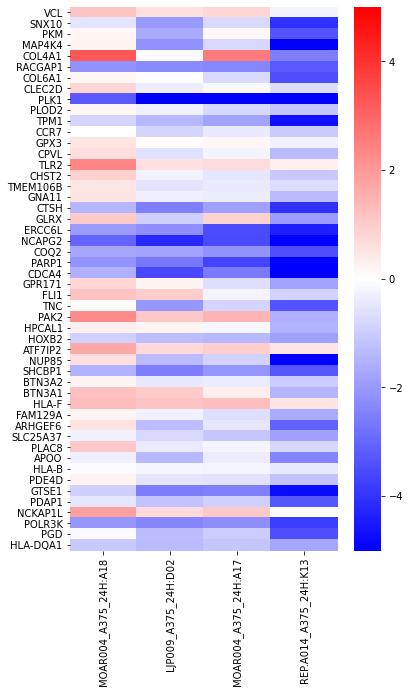

In [183]:
plt.figure(figsize=(6, 10))
sns.heatmap(pak4_tiec_im_selected.loc[dependence_pak4_gene[:50].index, :],
               vmin=-5, vmax=5,
               cmap='bwr')

In [184]:
pak4_tiec_im_selected.loc['GPX3', :]

MOAR004_A375_24H:A18     0.534195
LJP009_A375_24H:D02      0.054300
MOAR004_A375_24H:A17     0.180434
REP.A014_A375_24H:K13   -0.275250
Name: GPX3, dtype: float64

In [185]:
dependence_pak4_all = df(index=['pert_dose'])
for c in pak4_tiec_im.index:
    dependence_pak4_all.at[c, 'pert_dose'] = stats.spearmanr(pak4_tiec_im.T[c], pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'])[0]
dependence_pak4_all = dependence_pak4_all.dropna(axis=0, how='all')
dependence_pak4_all = dependence_pak4_all.sort_values(by='pert_dose', ascending=True)

In [188]:
dependence_pak4_all[:50]

,pert_dose
RNASEH2A,-0.948614
TTK,-0.929141
FBXO5,-0.926359
ECT2,-0.912450
KIF23,-0.909668
EED,-0.909668
EXO1,-0.906886
CTSC,-0.904104
POLR3K,-0.898540
NDC80,-0.892977


In [189]:
dependence_pak4_all[-50:]

,pert_dose
FAXDC2,0.737193
UBXN1,0.742756
PDLIM7,0.742756
PIK3IP1,0.745538
IL1B,0.745538
FHL1,0.748320
IFI27,0.748320
RND3,0.751102
ITGB7,0.753884
NR4A3,0.753884


In [191]:
dependence_pak4_all.to_csv(data_home + '/PAK4_case/dose_top_immune_sig_dependence_sorted.csv', sep=',')

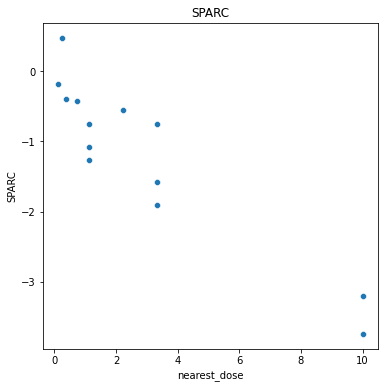

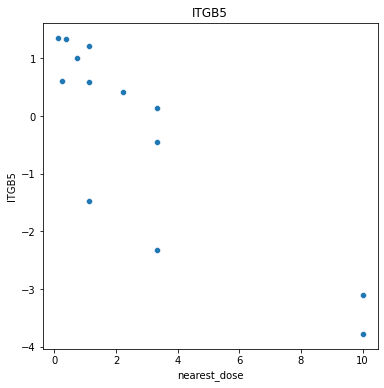

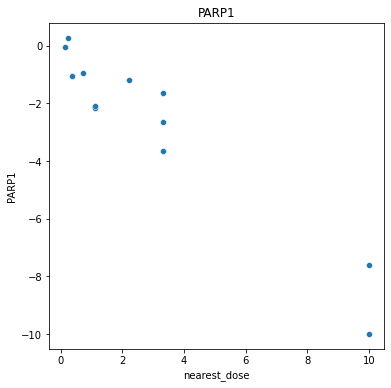

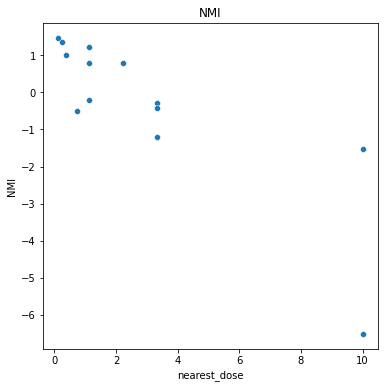

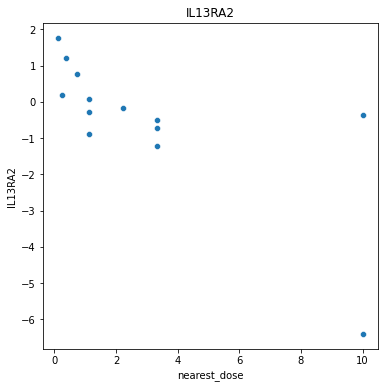

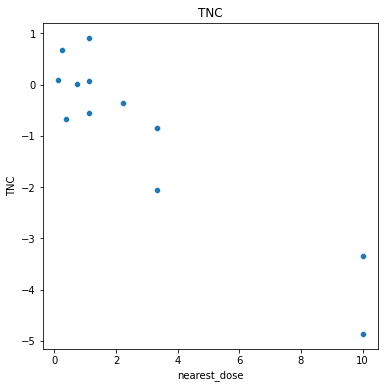

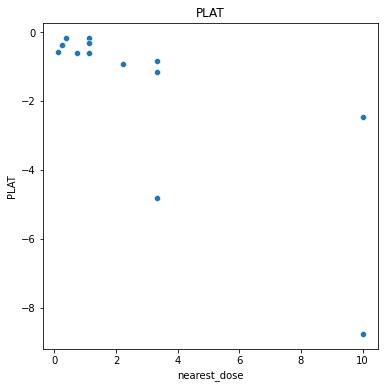

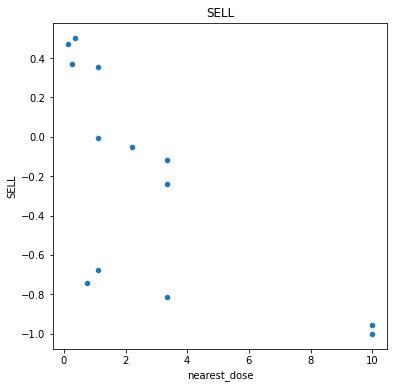

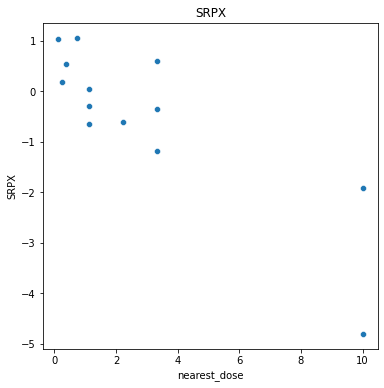

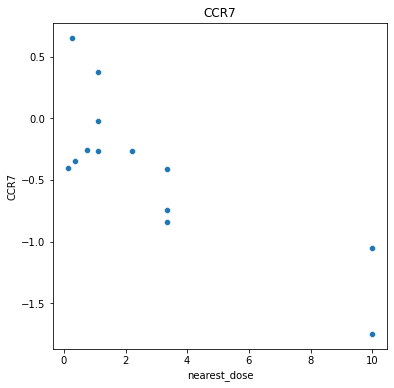

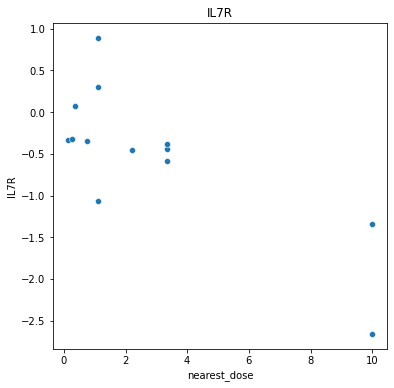

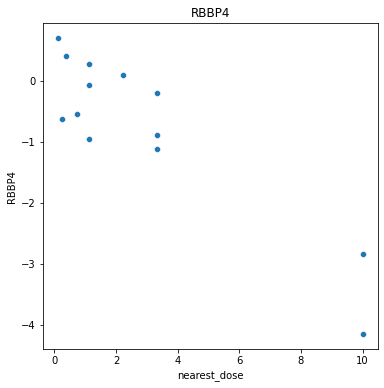

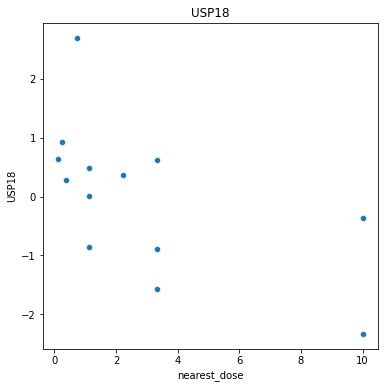

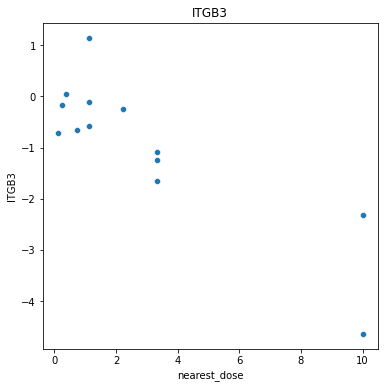

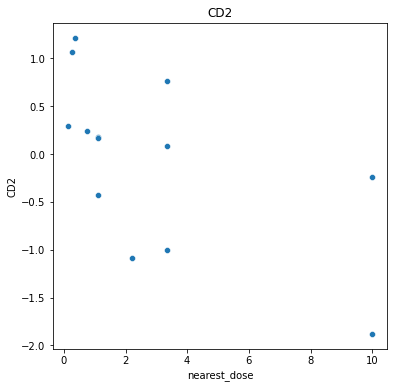

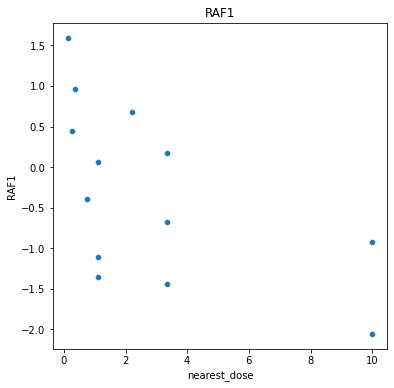

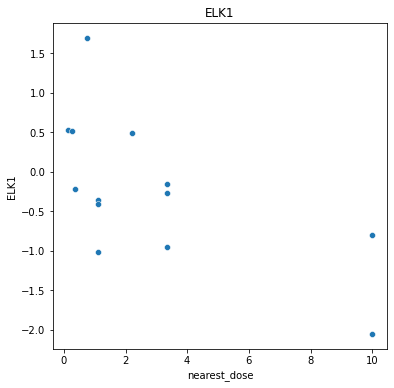

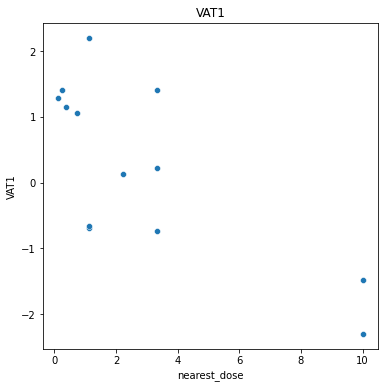

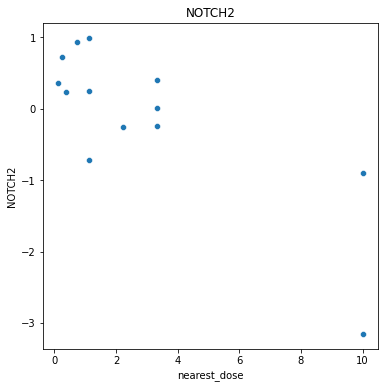

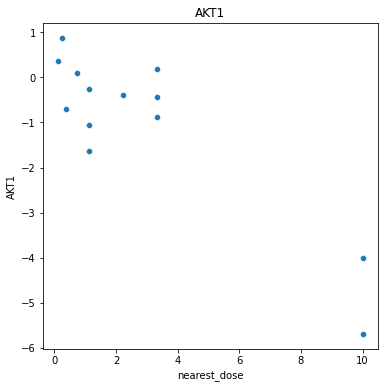

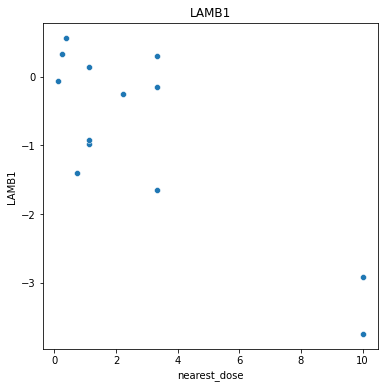

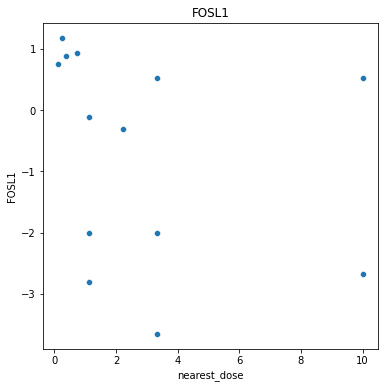

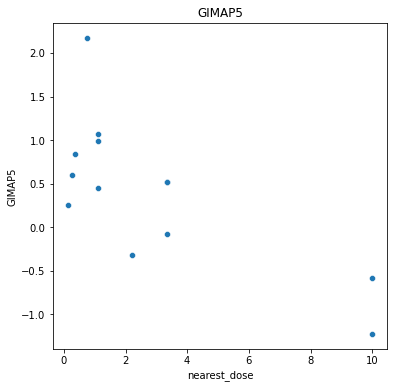

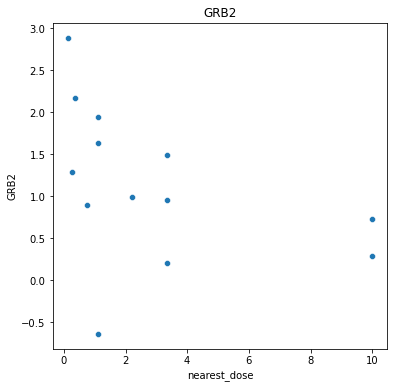

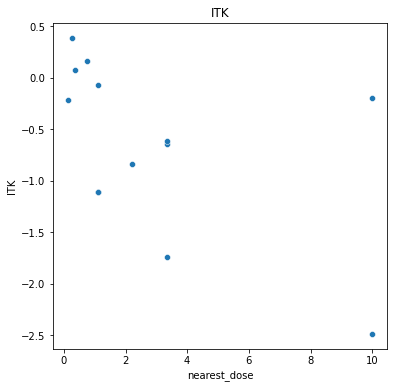

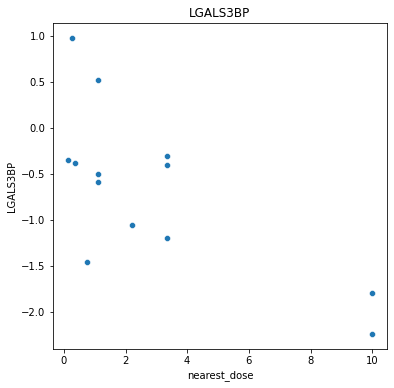

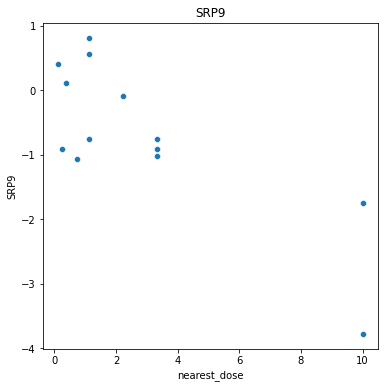

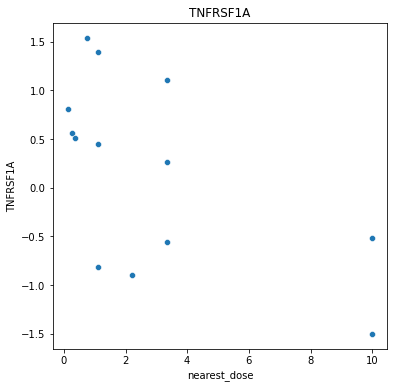

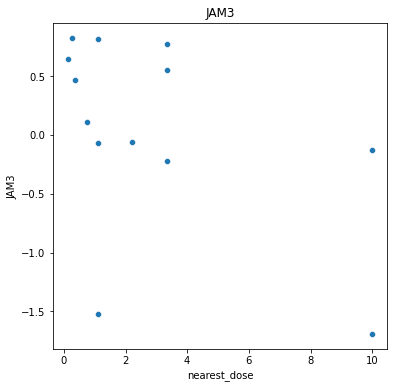

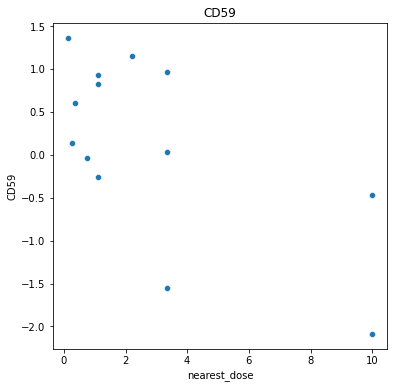

In [158]:
for g in dependence_pak4_all[:30].index:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec_im.T[g])
    plt.title(g)
    plt.show()

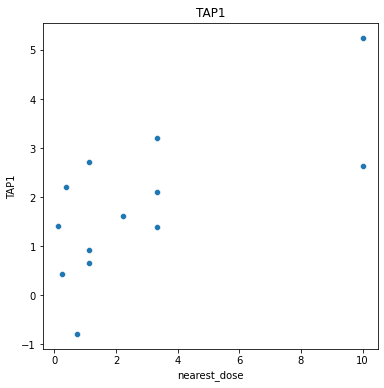

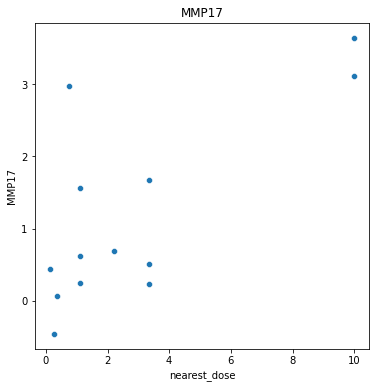

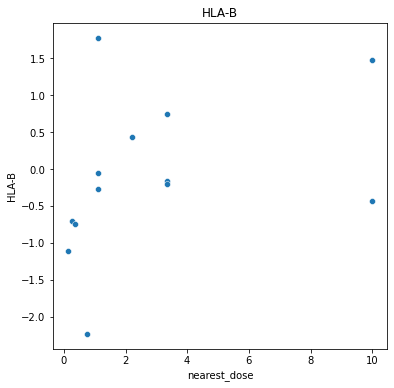

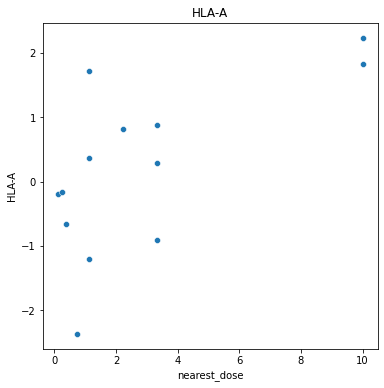

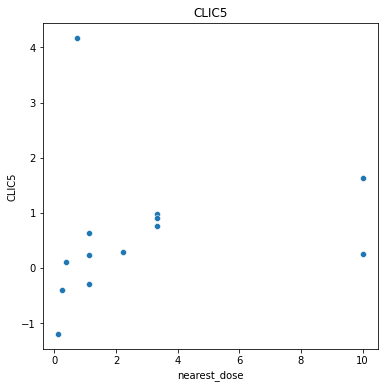

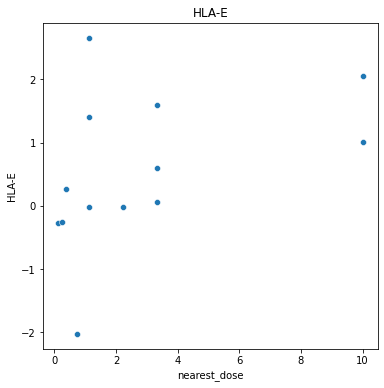

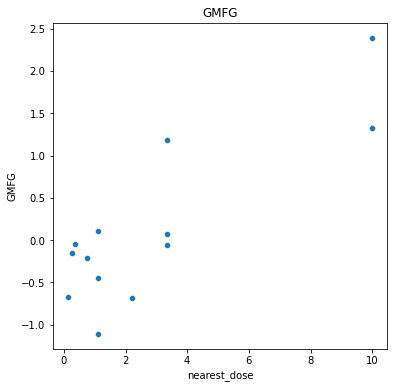

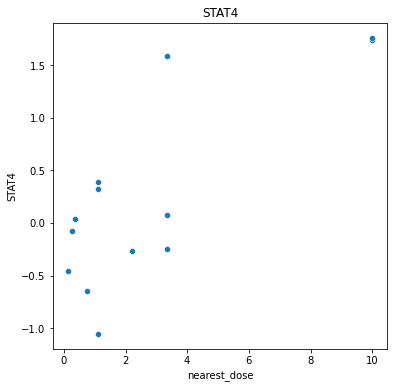

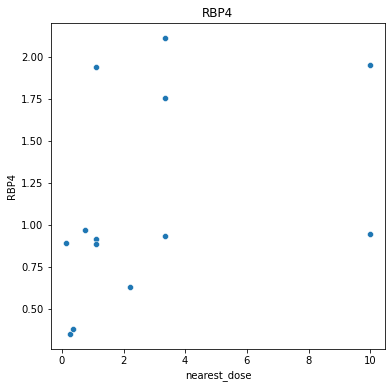

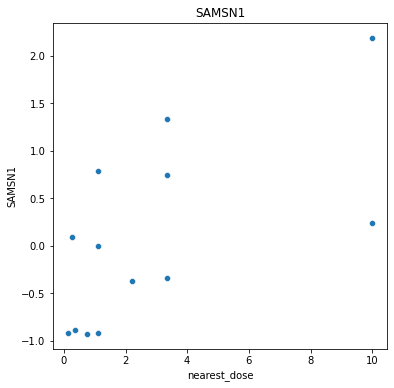

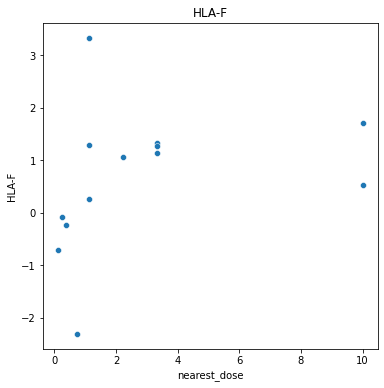

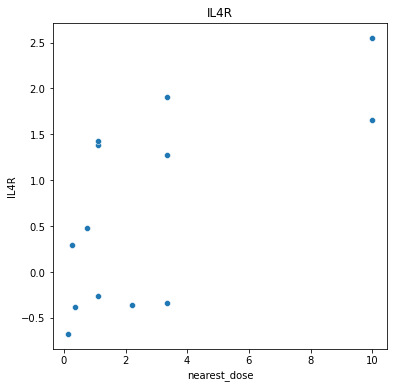

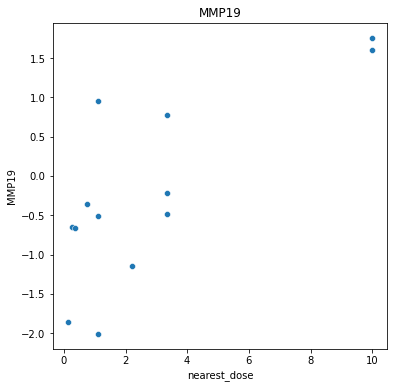

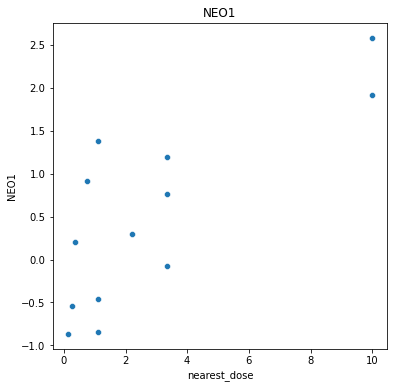

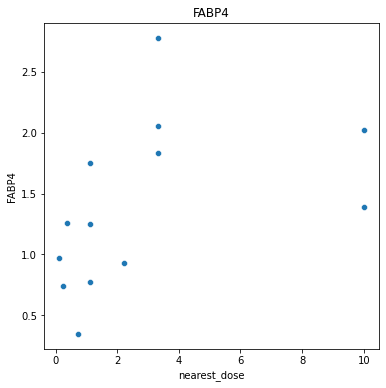

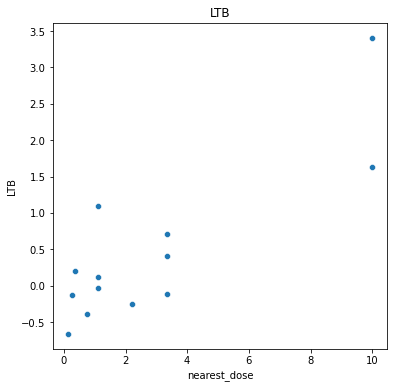

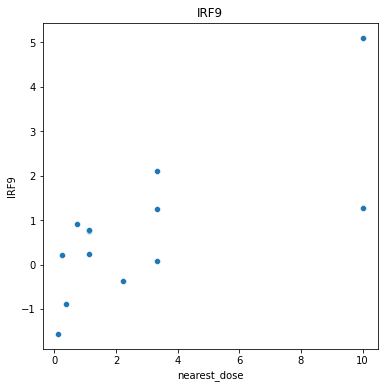

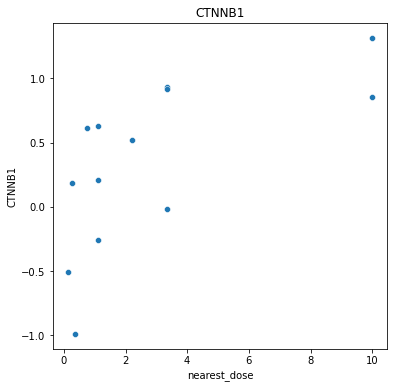

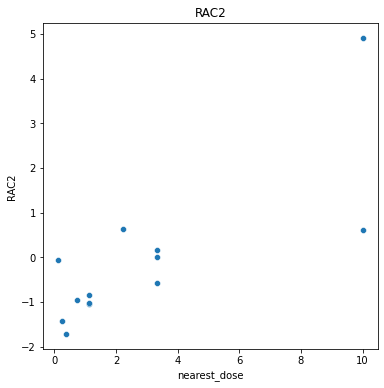

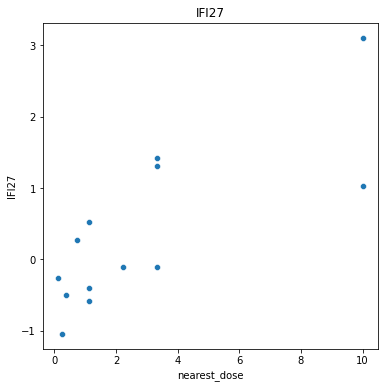

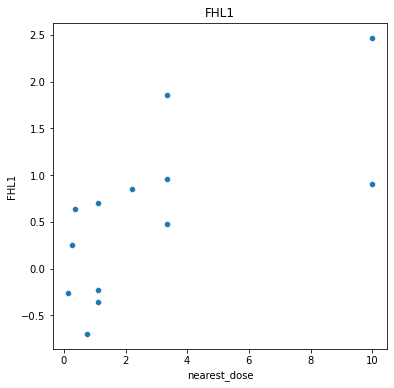

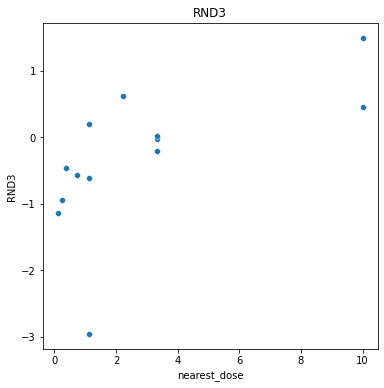

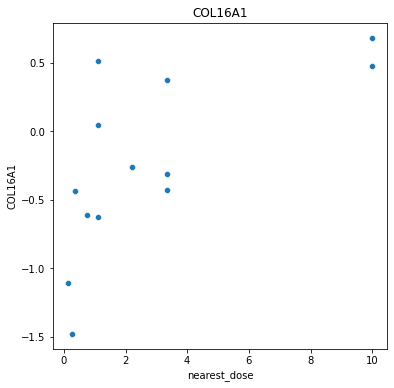

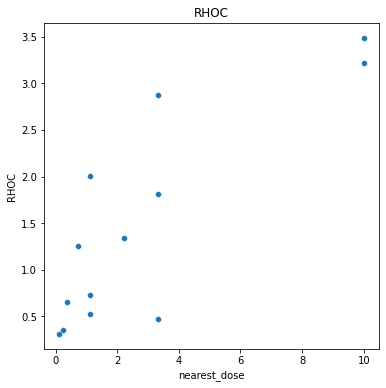

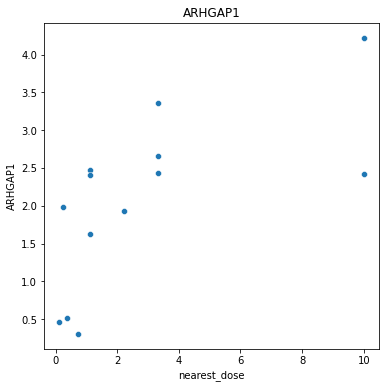

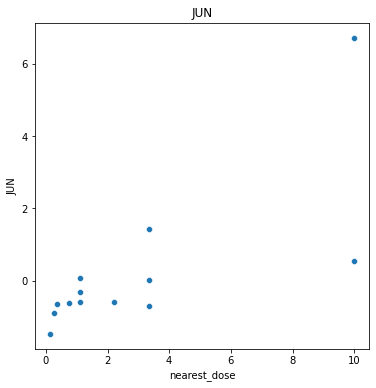

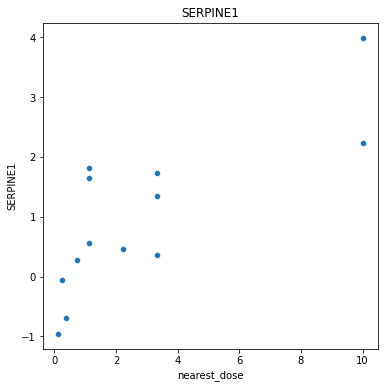

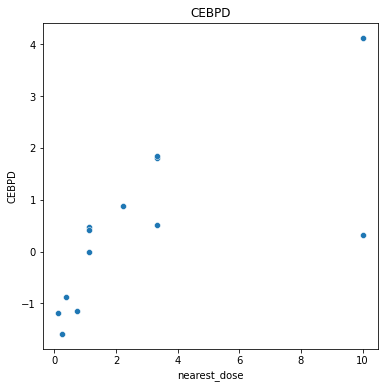

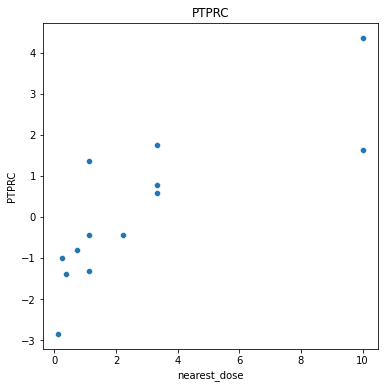

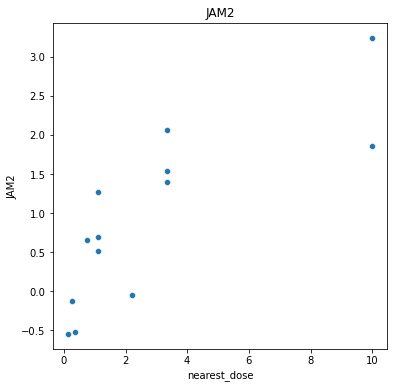

In [159]:
for g in dependence_pak4_all[-30:].index:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec_im.T[g])
    plt.title(g)
    plt.show()

<AxesSubplot:xlabel='nearest_dose', ylabel='shift_ability'>

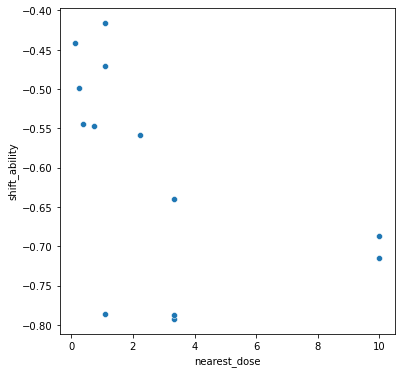

In [160]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=merged_es_compound.loc[pak4_tiec_im.columns, 'shift_ability'])

<AxesSubplot:xlabel='nearest_dose', ylabel='REC_profile'>

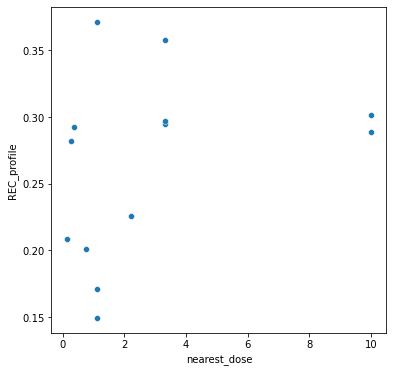

In [161]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=merged_es_compound.loc[pak4_tiec_im.columns, 'REC_profile'])

<AxesSubplot:xlabel='nearest_dose', ylabel='NREC_profile'>

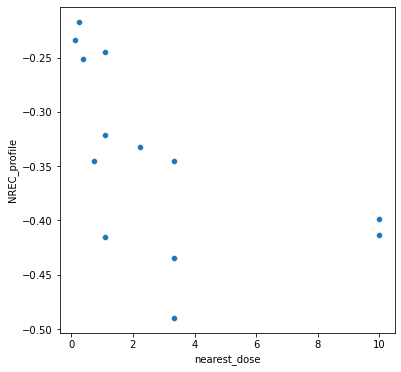

In [162]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=merged_es_compound.loc[pak4_tiec_im.columns, 'NREC_profile'])

<AxesSubplot:xlabel='nearest_dose', ylabel='PAK4'>

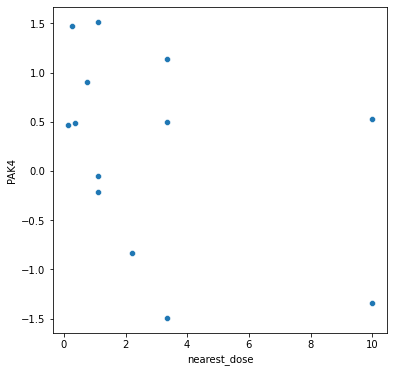

In [195]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'PAK4'])

<AxesSubplot:xlabel='nearest_dose', ylabel='PAK1'>

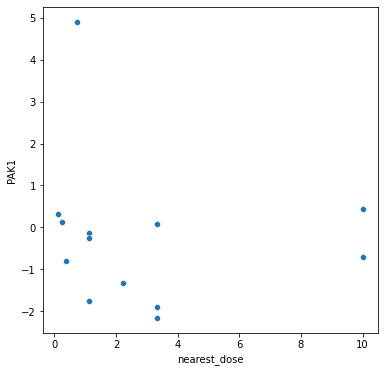

In [196]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'PAK1'])

<AxesSubplot:xlabel='nearest_dose', ylabel='PAK2'>

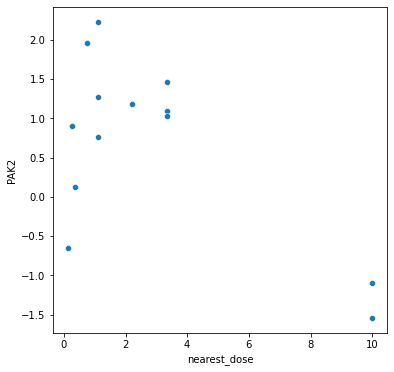

In [197]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'PAK2'])

<AxesSubplot:xlabel='nearest_dose', ylabel='PAK3'>

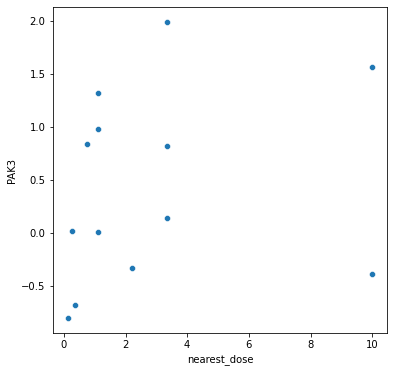

In [198]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'PAK3'])

<AxesSubplot:xlabel='nearest_dose', ylabel='EED'>

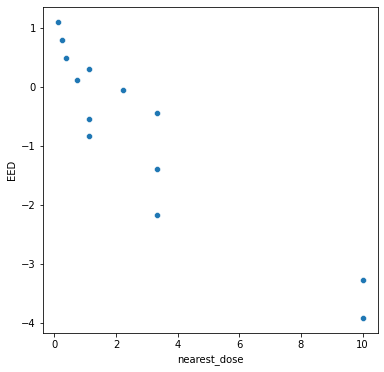

In [199]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'EED'])

<AxesSubplot:xlabel='nearest_dose', ylabel='ITGB5'>

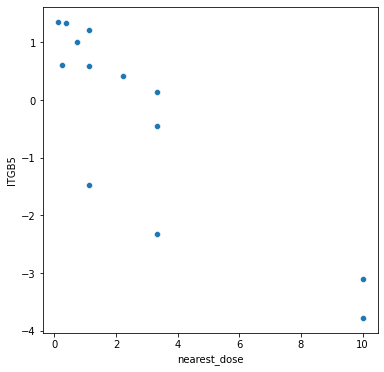

In [200]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'ITGB5'])

<AxesSubplot:xlabel='nearest_dose', ylabel='PARP1'>

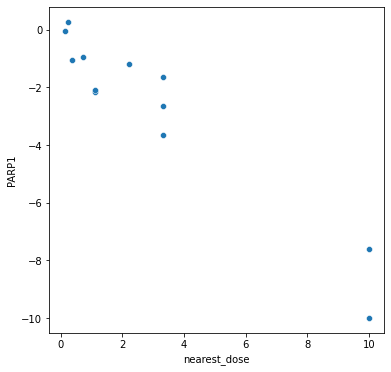

In [201]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'PARP1'])

<AxesSubplot:xlabel='nearest_dose', ylabel='PRF1'>

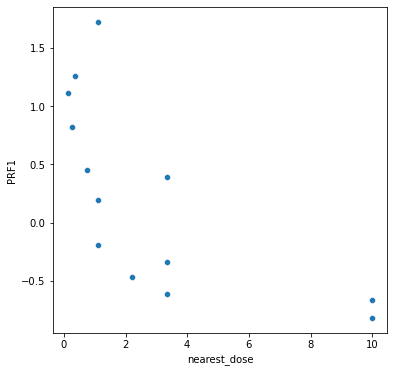

In [202]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'PRF1'])

<AxesSubplot:xlabel='nearest_dose', ylabel='IFNAR2'>

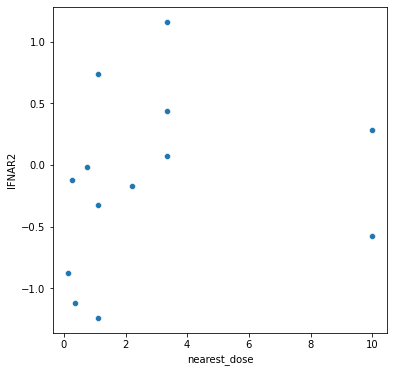

In [203]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'IFNAR2'])

<AxesSubplot:xlabel='nearest_dose', ylabel='IFNGR2'>

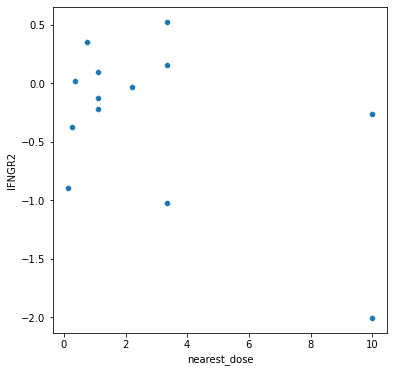

In [204]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'IFNGR2'])

<AxesSubplot:xlabel='nearest_dose', ylabel='IFNGR1'>

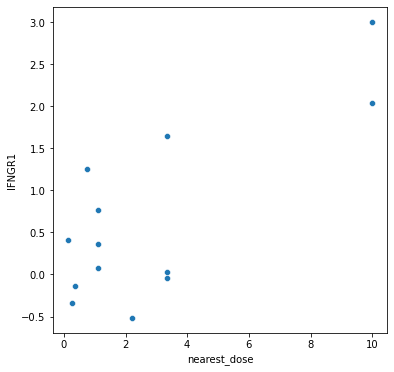

In [205]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'IFNGR1'])

<AxesSubplot:xlabel='nearest_dose', ylabel='STAT4'>

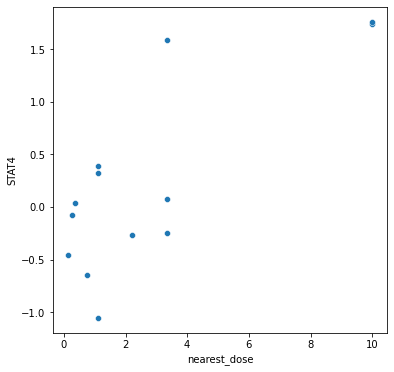

In [212]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'STAT4'])

In [207]:
stats.pearsonr(pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], pak4_tiec.T.loc[pak4_tiec_im.columns, 'IFNGR1'])

(0.7669718714253997, 0.0022179889849786648)

In [211]:
stats.pearsonr(pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], pak4_tiec.T.loc[pak4_tiec_im.columns, 'STAT4'])

(0.7867706188258096, 0.0014183004066664656)

<AxesSubplot:xlabel='nearest_dose', ylabel='TAP1'>

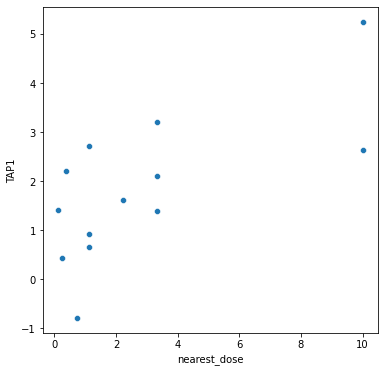

In [213]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'TAP1'])

<AxesSubplot:xlabel='nearest_dose', ylabel='TAP2'>

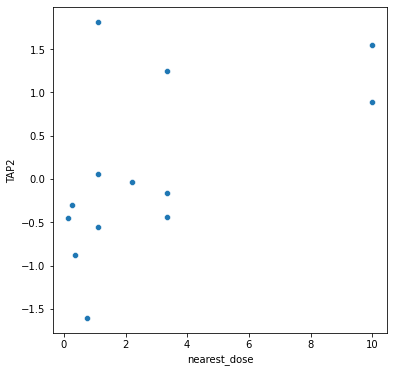

In [214]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'TAP2'])

<AxesSubplot:xlabel='nearest_dose', ylabel='IRF3'>

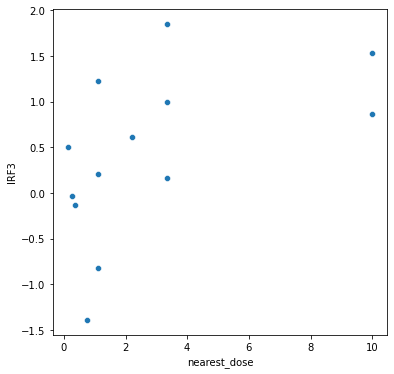

In [215]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'IRF3'])

<AxesSubplot:xlabel='nearest_dose', ylabel='TAPBPL'>

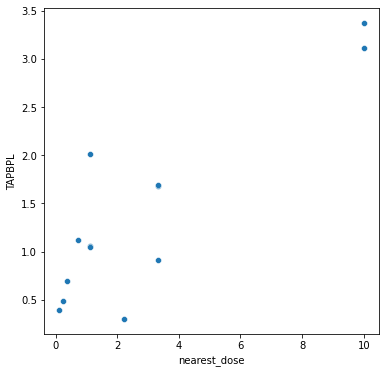

In [216]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'TAPBPL'])

<AxesSubplot:xlabel='nearest_dose', ylabel='HLA-A'>

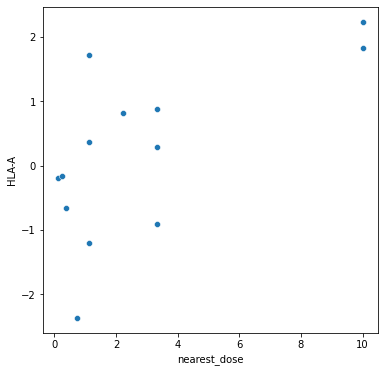

In [217]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'HLA-A'])

<AxesSubplot:xlabel='nearest_dose', ylabel='HLA-B'>

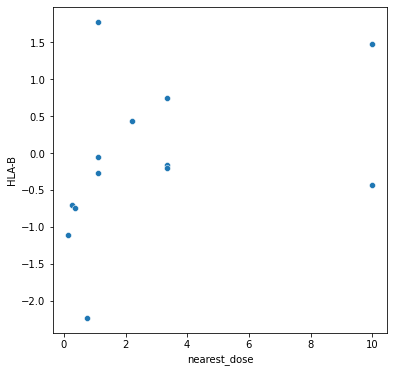

In [218]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'HLA-B'])

<AxesSubplot:xlabel='nearest_dose', ylabel='TGFB2'>

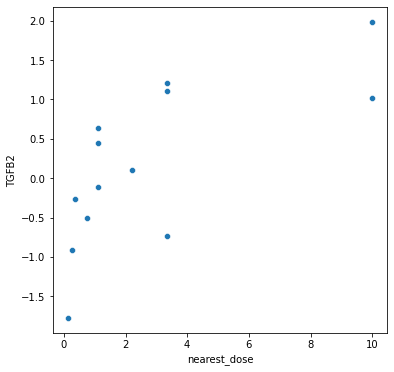

In [219]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'TGFB2'])

<AxesSubplot:xlabel='nearest_dose', ylabel='ITGB5'>

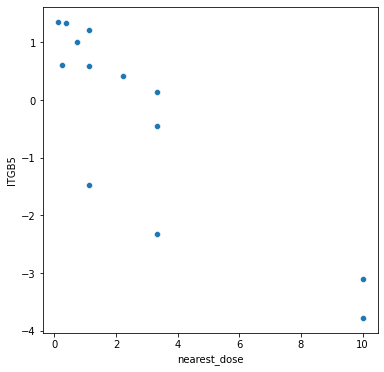

In [220]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'ITGB5'])

<AxesSubplot:xlabel='nearest_dose', ylabel='EZH2'>

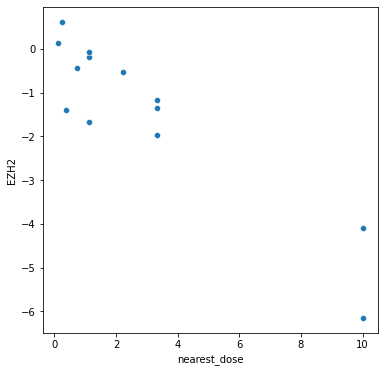

In [221]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'EZH2'])

<AxesSubplot:xlabel='nearest_dose', ylabel='CDKN1A'>

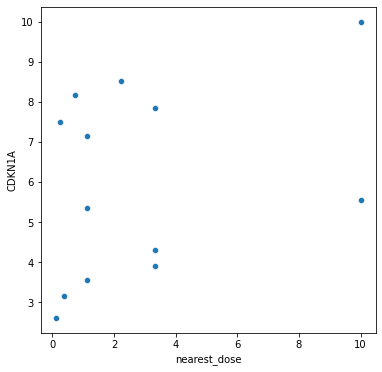

In [222]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=pak4_all.loc[pak4_tiec_im.columns, 'nearest_dose'], y=pak4_tiec.T.loc[pak4_tiec_im.columns, 'CDKN1A'])

# Dosage statistics

In [248]:
skcm_sig_24 = skcm_sig_info[skcm_sig_info['pert_time'] == 24.]
skcm_sig_24 = skcm_sig_24[skcm_sig_24['cell_mfc_name'] == 'A375']

In [249]:
drug_dosage = pd.crosstab(skcm_sig_24['cmap_name'], skcm_sig_24['pert_idose'])

In [250]:
drug_dosage

pert_idose,0.01 uM,0.025 uM,0.03 uM,0.04 uM,0.08 uM,0.12 uM,0.125 uM,0.25 uM,0.3 uM,0.37 uM,...,200 uM,3.33 uM,30 uM,4 uM,40 uM,50 uM,60 uM,8 uM,80 uM,90 uM
cmap_name,,,,,,,,,,,,,,,,,,,,,
10-DEBC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1B,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3-Cl-AHPC,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
5-BDBD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-iodotubercidin,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wortmannin,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
zafirlukast,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zardaverine,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


In [251]:
drug_dosage.to_csv(data_home + '/dosage/skcm_dosage_drug_table_24h_A375.csv', sep=',')

In [252]:
drug_dosage_count = df(drug_dosage.sum(axis=1)).rename(columns={0: 'dosage_count'})
drug_dosage_count

,dosage_count
cmap_name,
10-DEBC,1
1B,4
3-Cl-AHPC,4
5-BDBD,1
5-iodotubercidin,2
...,...
wortmannin,24
zafirlukast,1
zardaverine,7


In [253]:
drug_dosage_count.loc['PF-03758309', :]

dosage_count    13
Name: PF-03758309, dtype: int64

<AxesSubplot:xlabel='dosage_count', ylabel='Density'>

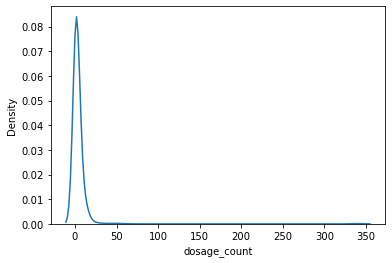

In [254]:
sns.kdeplot(drug_dosage_count['dosage_count'])

In [255]:
drug_dosage_multi = drug_dosage_count[drug_dosage_count['dosage_count'] >= 5]
drug_dosage_multi

,dosage_count
cmap_name,
AMG-232,5
AP-26113,5
AS-605240,5
AS-703026,16
AT-13387,7
...,...
volasertib,19
vorinostat,62
withaferin-a,21


In [256]:
drug_dosage_multi_hi = drug_dosage_count[drug_dosage_count['dosage_count'] >= 10]
drug_dosage_multi_hi

,dosage_count
cmap_name,
AS-703026,16
AZ-628,14
AZD-7762,16
AZD-8330,20
BI-2536,22
...,...
vemurafenib,16
volasertib,19
vorinostat,62


# Correlation between dosage and shift ability

In [268]:
dosage_multi_shift = df(index=drug_dosage_multi.index, columns=['NREC','NREC_p', 'REC', 'REC_p', 'shift_ability', 'shift_ability_p'])
for d in drug_dosage_multi.index:
    tmp_do = df(skcm_sig_24[skcm_sig_24['cmap_name'] == d]['nearest_dose'])
    tmp_merge = tmp_do.copy()
    tmp_merge['NREC'] = merged_es_compound['NREC_profile']
    tmp_merge['REC'] = merged_es_compound['REC_profile']
    tmp_merge['shift_ability'] = merged_es_compound['shift_ability']
    dosage_multi_shift.at[d, 'NREC'], dosage_multi_shift.at[d, 'NREC_p'] = stats.spearmanr(tmp_merge['nearest_dose'], tmp_merge['NREC'])
    dosage_multi_shift.at[d, 'REC'], dosage_multi_shift.at[d, 'REC_p'] = stats.spearmanr(tmp_merge['nearest_dose'], tmp_merge['REC'])
    dosage_multi_shift.at[d, 'shift_ability'], dosage_multi_shift.at[d, 'shift_ability_p'] = stats.spearmanr(tmp_merge['nearest_dose'], tmp_merge['shift_ability'])
dosage_multi_shift = dosage_multi_shift.astype(float)

In [269]:
dosage_multi_shift

,NREC,NREC_p,REC,REC_p,shift_ability,shift_ability_p
cmap_name,,,,,,
AMG-232,-0.300000,0.623838,-0.100000,0.872889,-0.200000,0.747060
AP-26113,-0.632456,0.252215,0.000000,1.000000,-0.210819,0.733579
AS-605240,-0.300000,0.623838,-0.200000,0.747060,0.200000,0.747060
AS-703026,-0.267160,0.317169,0.318821,0.228759,-0.258304,0.334078
AT-13387,-0.500000,0.253170,0.642857,0.119392,-0.678571,0.093750
...,...,...,...,...,...,...
volasertib,-0.852116,0.000004,-0.172189,0.480877,-0.380582,0.107952
vorinostat,-0.367703,0.003281,0.384207,0.002050,-0.444797,0.000292
withaferin-a,0.344708,0.125950,-0.330194,0.143781,0.416553,0.060325


In [270]:
dosage_multi_shift.to_csv(data_home + '/dosage/corr_multi_dosage_shift_24h_A375.csv', sep=',')

In [271]:
dosage_multi_shift.loc['PF-03758309', :]

NREC              -0.726065
NREC_p             0.004953
REC                0.478480
REC_p              0.098122
shift_ability     -0.698247
shift_ability_p    0.007944
Name: PF-03758309, dtype: float64

In [273]:
dosage_multi_shift.sort_values(by='shift_ability_p', ascending=True)[:20]

,NREC,NREC_p,REC,REC_p,shift_ability,shift_ability_p
cmap_name,,,,,,
mitoxantrone,0.772042,8.295547e-11,-0.284642,0.047448,0.614485,0.000003
vorinostat,-0.367703,3.280768e-03,0.384207,0.002050,-0.444797,0.000292
MLN-4924,-0.872727,4.546151e-04,0.736364,0.009760,-0.881818,0.000330
bromosporine,-0.954314,8.360075e-04,0.449089,0.312098,-0.954314,0.000836
entinostat,-0.706076,4.769406e-03,0.665984,0.009316,-0.784034,0.000903
dasatinib,-0.594929,5.252876e-04,0.465695,0.009501,-0.541662,0.001992
PIK-75,-0.714286,7.134356e-02,0.928571,0.002519,-0.928571,0.002519
MG-132,0.069626,1.983244e-01,-0.134759,0.012487,0.153401,0.004406
epirubicin,0.828571,4.156268e-02,-0.771429,0.072397,0.942857,0.004805


In [274]:
dosage_multi_hi_shift = dosage_multi_shift[dosage_multi_shift.index.isin(drug_dosage_multi_hi.index)]

In [276]:
dosage_multi_hi_shift.sort_values(by='shift_ability_p', ascending=True)[:10]

,NREC,NREC_p,REC,REC_p,shift_ability,shift_ability_p
cmap_name,,,,,,
mitoxantrone,0.772042,8.295547e-11,-0.284642,0.047448,0.614485,0.000003
vorinostat,-0.367703,3.280768e-03,0.384207,0.002050,-0.444797,0.000292
MLN-4924,-0.872727,4.546151e-04,0.736364,0.009760,-0.881818,0.000330
entinostat,-0.706076,4.769406e-03,0.665984,0.009316,-0.784034,0.000903
dasatinib,-0.594929,5.252876e-04,0.465695,0.009501,-0.541662,0.001992
MG-132,0.069626,1.983244e-01,-0.134759,0.012487,0.153401,0.004406
OTS-167,-0.508775,9.118080e-02,0.807023,0.001509,-0.747373,0.005206
PF-03758309,-0.726065,4.952569e-03,0.478480,0.098122,-0.698247,0.007944
TAK-733,-0.748252,5.124082e-03,0.678322,0.015317,-0.699301,0.011374


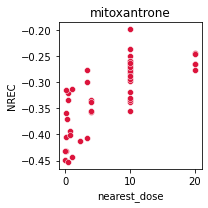

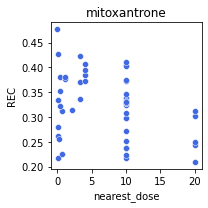

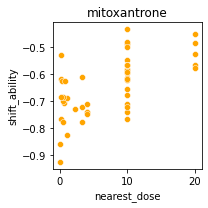

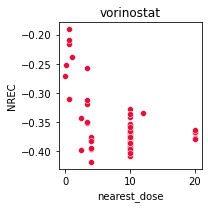

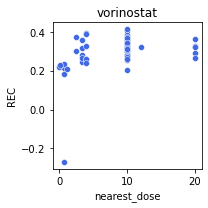

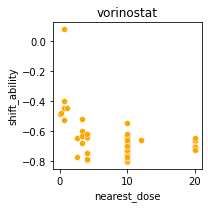

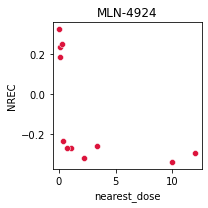

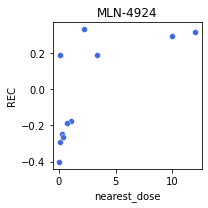

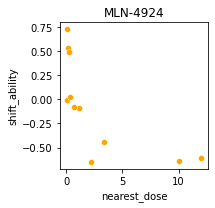

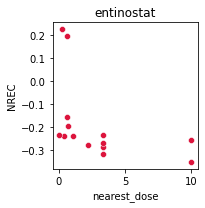

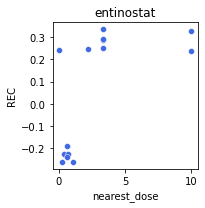

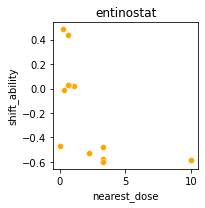

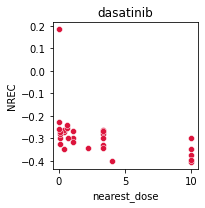

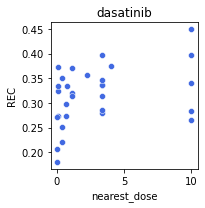

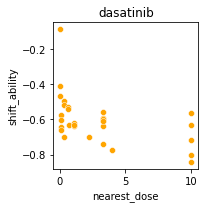

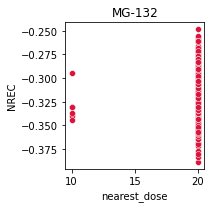

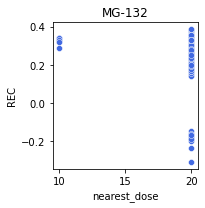

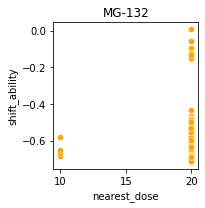

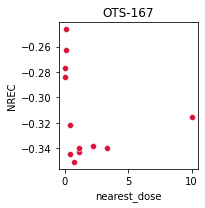

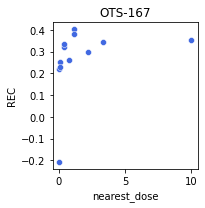

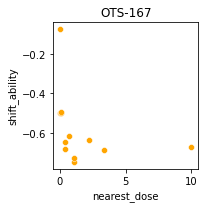

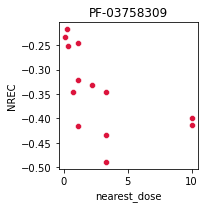

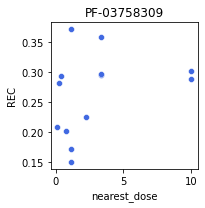

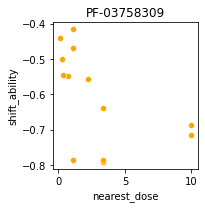

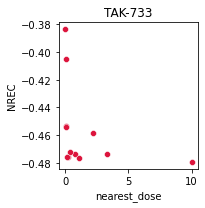

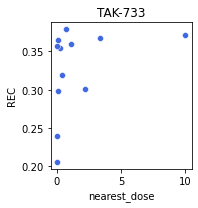

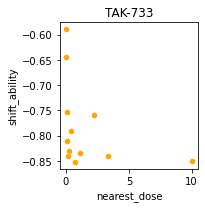

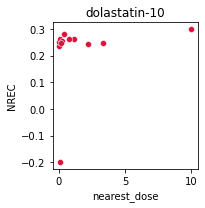

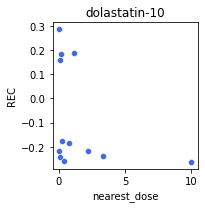

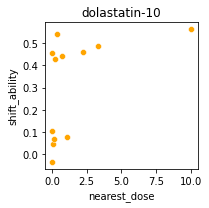

In [290]:
for d in dosage_multi_hi_shift.sort_values(by='shift_ability_p', ascending=True)[:10].index:
    tmp_do = df(skcm_sig_24[skcm_sig_24['cmap_name'] == d]['nearest_dose'])
    tmp_merge = tmp_do.copy()
    tmp_merge['NREC'] = merged_es_compound['NREC_profile']
    tmp_merge['REC'] = merged_es_compound['REC_profile']
    tmp_merge['shift_ability'] = merged_es_compound['shift_ability']
    
    plt.figure(figsize=(3, 3))
    sns.scatterplot(x='nearest_dose', y='NREC', data=tmp_merge, color='crimson')
    plt.title(d)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(3, 3))
    sns.scatterplot(x='nearest_dose', y='REC', data=tmp_merge, color='royalblue')
    plt.title(d)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(3, 3))
    sns.scatterplot(x='nearest_dose', y='shift_ability', data=tmp_merge, color='orange')
    plt.title(d)
    plt.tight_layout()
    plt.show()

# Correlation between dosage and gene expression

"consistent alteration score": whether a sets of genes have the same-direction dosage-dependence

In [293]:
dosage_gene_corr = df(columns=drug_dosage_multi.index, index=skcm_trt_cp_original.index)
dosage_gene_p = df(columns=drug_dosage_multi.index, index=skcm_trt_cp_original.index)
for d in drug_dosage_multi.index:
    tmp_do = df(skcm_sig_24[skcm_sig_24['cmap_name'] == d]['nearest_dose'])
    tmp_tiec = skcm_trt_cp_original[tmp_do.index]
    for g in tmp_tiec.index:
        dosage_gene_corr.at[g, d], dosage_gene_p.at[g, d] = stats.spearmanr(tmp_do['nearest_dose'], tmp_tiec.T.loc[tmp_do.index, g])
dosage_gene_corr = dosage_gene_corr.astype(float)
dosage_gene_p = dosage_gene_p.astype(float)

In [294]:
dosage_gene_corr.to_csv(data_home + '/dosage/spr_corr_multi_dosage_TIEC_24h_A375.csv', sep=',')
dosage_gene_p.to_csv(data_home + '/dosage/spr_p_multi_dosage_TIEC_24h_A375.csv', sep=',')

In [359]:
dosage_gene_corr.shape

(10174, 195)

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


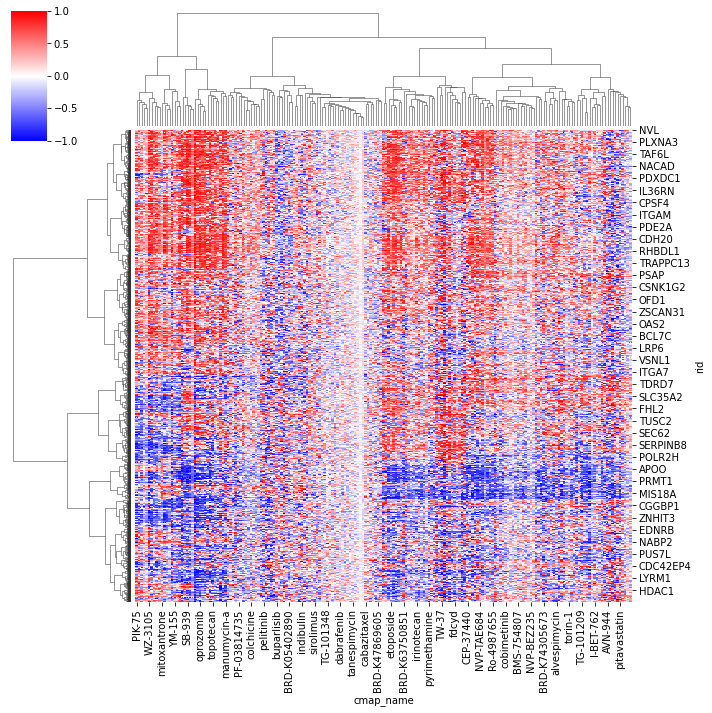

In [366]:
sns.clustermap(dosage_gene_corr.dropna(axis=1, how='all').fillna(0),
               vmin=-1, vmax=1, method='ward', cmap='bwr')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


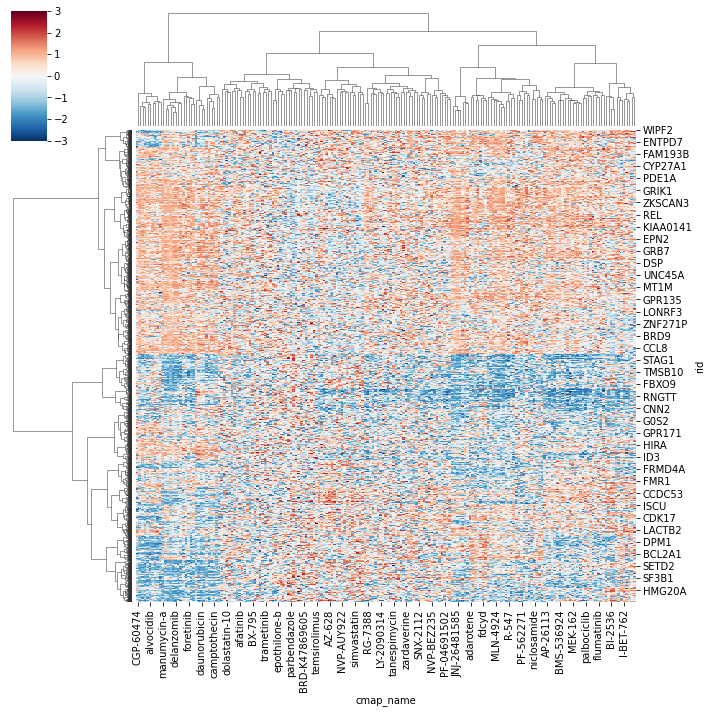

In [429]:
sns.clustermap(dosage_gene_corr.dropna(axis=1, how='all').fillna(0),
               z_score=1,
               vmin=-3, vmax=3, method='ward', cmap='RdBu_r')

In [387]:
dosage_gene_corr['PF-03758309'].sort_values()

rid
KIF20A     -0.961062
BUB1       -0.948614
RNASEH2A   -0.948614
ETV1       -0.937487
TLE1       -0.931923
              ...   
PRKRIP1     0.915232
VPS13B      0.920795
LIMS2       0.923577
TXN2        0.929141
PTK2B       0.959741
Name: PF-03758309, Length: 10174, dtype: float64

In [388]:
dosage_gene_corr.loc['PAK4', 'PF-03758309']

-0.2920952070258896

In [414]:
dosage_gene_p.loc['PAK4', 'PF-03758309']

0.3328488279270615

In [389]:
dosage_gene_corr.loc['PAK1', 'PF-03758309']

-0.30044078436948646

In [390]:
dosage_gene_corr.loc['PAK2', 'PF-03758309']

-0.1363110966120818

In [391]:
dosage_gene_corr.loc['PAK3', 'PF-03758309']

0.4089332898362454

In [392]:
dosage_gene_corr.loc['IFNGR1', 'PF-03758309']

0.4256244445234391

In [412]:
dosage_gene_p.loc['IFNGR1', 'PF-03758309']

0.1470515149712224

In [393]:
dosage_gene_corr.loc['IFNGR2', 'PF-03758309']

-0.07789205520690387

In [394]:
dosage_gene_corr.loc['TAP1', 'PF-03758309']

0.5869722731663114

In [395]:
dosage_gene_corr.loc['TAP2', 'PF-03758309']

0.6008815687389729

In [396]:
dosage_gene_corr.loc['HLA-A', 'PF-03758309']

0.592535991395376

In [397]:
dosage_gene_corr.loc['HLA-B', 'PF-03758309']

0.592535991395376

In [398]:
dosage_gene_corr.loc['HLA-C', 'PF-03758309']

0.5257713726466012

In [399]:
dosage_gene_corr.loc['EZH2', 'PF-03758309']

-0.7594475382673129

In [413]:
dosage_gene_p.loc['EZH2', 'PF-03758309']

0.0026003261366987157

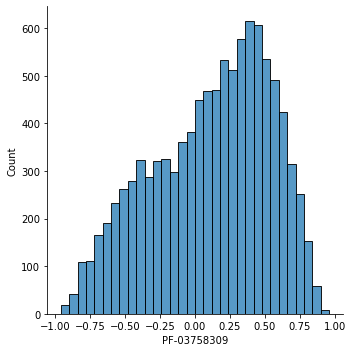

In [404]:
sns.displot(dosage_gene_corr['PF-03758309'])

# Dosage Dependence

In [465]:
def dose_tas(drug_name, dosage_dependence, sig_info):
    # dosage_gene_corr distribution
    plt.figure(figsize=(3, 3))
    sns.kdeplot(dosage_dependence[drug_name])
    plt.axvline(x=0., ls=':', c='k')
    plt.title('dosage-gene dependence: ' + drug_name)
    plt.show()
    
    # dosage tas dependence
    plt.figure(figsize=(3, 3))
    sns.scatterplot(x='pert_dose', y='tas', data=sig_info[sig_info['cmap_name'] == drug_name])
    plt.title('dosage-tas dependence: ' + drug_name)
    plt.show()
    return

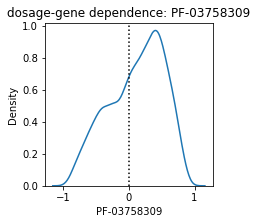

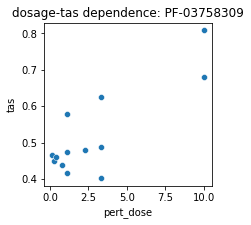

In [466]:
dose_tas(drug_name='PF-03758309',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

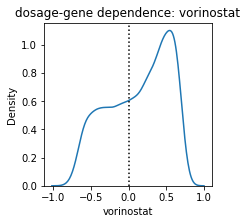

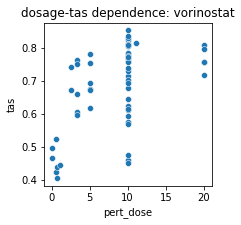

In [467]:
dose_tas(drug_name='vorinostat',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

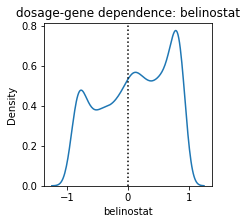

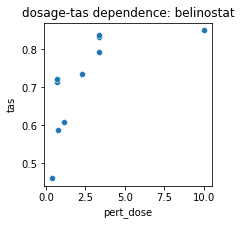

In [512]:
dose_tas(drug_name='belinostat',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

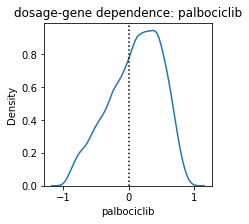

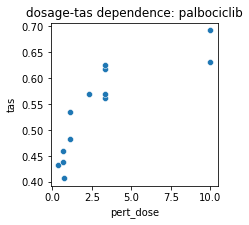

In [468]:
dose_tas(drug_name='palbociclib',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

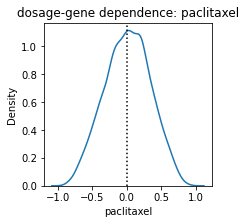

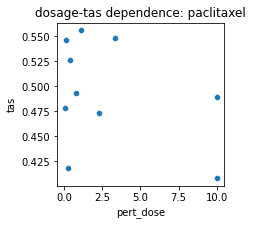

In [470]:
dose_tas(drug_name='paclitaxel',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

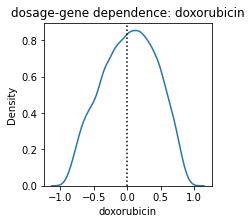

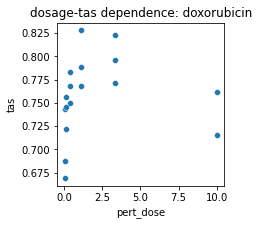

In [471]:
dose_tas(drug_name='doxorubicin',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

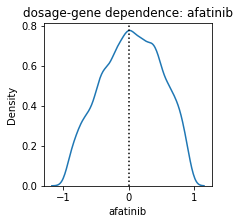

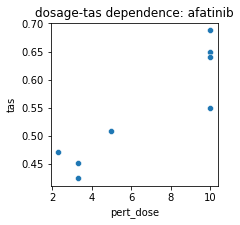

In [472]:
dose_tas(drug_name='afatinib',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

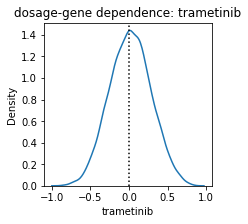

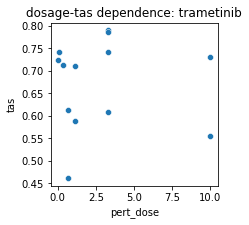

In [475]:
dose_tas(drug_name='trametinib',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

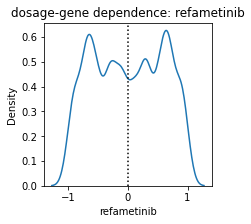

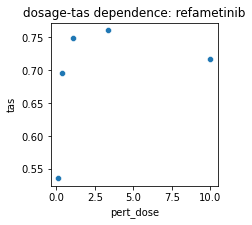

In [476]:
dose_tas(drug_name='refametinib',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

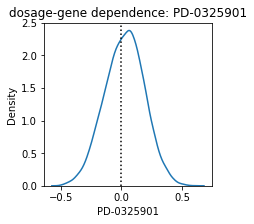

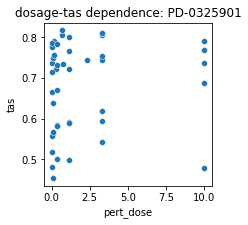

In [477]:
dose_tas(drug_name='PD-0325901',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

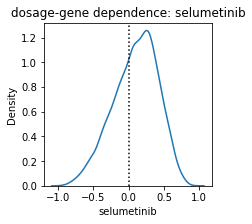

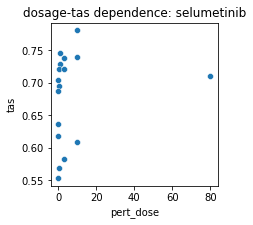

In [478]:
dose_tas(drug_name='selumetinib',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

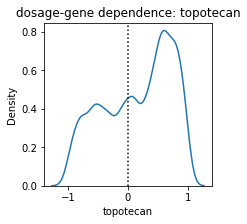

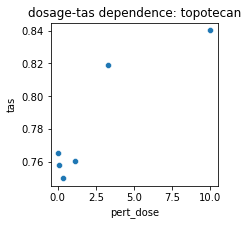

In [519]:
dose_tas(drug_name='topotecan',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

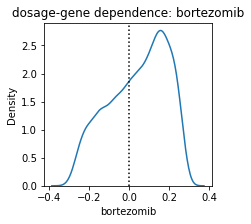

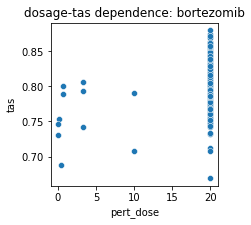

In [527]:
dose_tas(drug_name='bortezomib',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

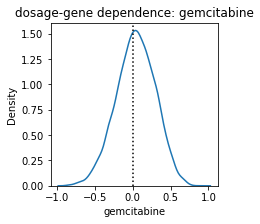

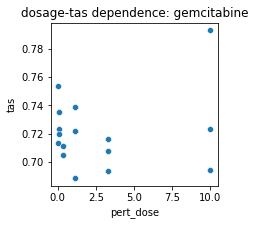

In [539]:
dose_tas(drug_name='gemcitabine',
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)

In [480]:
# read the drug response information from ctrp
ctrp_res = pd.read_csv(data_home + '/CTRP/CMAP2020_CTRP_shift_ability_A375_24h.csv',
                       header=0, index_col=0, sep=',')

In [482]:
ctrp_res = ctrp_res.dropna(axis=0, how='any')
ctrp_res

,NREC_profile,REC_profile,cmap_name,shift_ability,dose,time,cell_line,dose_cat,dose_color,CTRP_ID,CTRP_auc_v21,CTRP_res_v21,tas
PBIOA017_A375_24H:M01,-0.487790,0.380280,GDC-0879,-0.868070,10.00,24.0,A375,medium,moccasin,606248,10.6120,resistance,0.767915
BRAF001_A375_24H:BRD-K67578145-001-05-5:10,-0.487540,0.414883,GDC-0879,-0.902423,10.00,24.0,A375,medium,moccasin,606248,10.6120,resistance,0.794273
PBIOA015_A375_24H:M01,-0.485613,0.380741,vemurafenib,-0.866354,10.00,24.0,A375,medium,moccasin,649420,11.3670,resistance,0.706383
PBIOA017_A375_24H:N03,-0.484179,0.424258,PLX-4720,-0.908437,1.11,24.0,A375,low,royalblue,606256,11.3710,resistance,0.730157
REP.A015_A375_24H:E19,-0.484035,0.406539,selumetinib,-0.890575,10.00,24.0,A375,medium,moccasin,348991,8.3986,sensitive,0.739556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
LJP007_A375_24H:L04,0.298017,-0.312779,SB-525334,0.610796,0.37,24.0,A375,low,royalblue,639962,14.9660,resistance,0.418661
REP.A009_A375_24H:F19,0.300381,-0.251986,KX-2391,0.552367,10.00,24.0,A375,medium,moccasin,660779,8.6803,sensitive,0.550884
REP.A002_A375_24H:G08,0.307575,-0.255910,sotrastaurin,0.563485,3.33,24.0,A375,low,royalblue,661032,14.6220,resistance,0.429111
MOAR005_A375_24H:L03,0.322656,-0.380208,GMX-1778,0.702864,1.11,24.0,A375,low,royalblue,411843,12.9060,resistance,0.427290


In [483]:
pd.crosstab(ctrp_res['cmap_name'], ctrp_res['CTRP_res_v21'])

CTRP_res_v21,resistance,resistance+,sensitive,sensitive+
cmap_name,,,,
1B,4,0,0,0
3-Cl-AHPC,4,0,0,0
7b-cis,4,0,0,0
AVA,1,0,0,0
AZD-4547,2,0,0,0
...,...,...,...,...
tubastatin-a,2,0,0,0
valdecoxib,1,0,0,0
vandetanib,2,0,0,0


## 1. Relationship between TAS, dosage-dependence and drug response

In [496]:
# drug resistance
resist_plus_list = ctrp_res[ctrp_res['CTRP_res_v21'] == 'resistance+']
resist_list = ctrp_res[ctrp_res['CTRP_res_v21'] == 'resistance']
print(resist_plus_list.shape)
print(resist_list.shape)
print(resist_plus_list['cmap_name'].unique().shape)
print(resist_list['cmap_name'].unique().shape)

(102, 13)
(1136, 13)
(29,)
(162,)


In [497]:
# drug sensitivity
sensi_plus_list = ctrp_res[ctrp_res['CTRP_res_v21'] == 'sensitive+']
sensi_list = ctrp_res[ctrp_res['CTRP_res_v21'] == 'sensitive']
print(sensi_plus_list.shape)
print(sensi_list.shape)
print(sensi_plus_list['cmap_name'].unique().shape)
print(sensi_list['cmap_name'].unique().shape)

(26, 13)
(218, 13)
(3,)
(25,)


In [491]:
# moa enriched in resistant plus drugs
compound_info[compound_info.index.isin(resist_plus_list['cmap_name'])]['moa'].value_counts()

MTOR inhibitor                                2
KIT inhibitor                                 2
PI3K inhibitor                                2
HSP inhibitor                                 1
FAAH inhibitor                                1
FGFR inhibitor                                1
PKC inhibitor                                 1
NFKB pathway inhibitor                        1
BCL inhibitor                                 1
Breast cancer resistance protein inhibitor    1
Retinoid receptor agonist                     1
IGF-1 inhibitor                               1
Caspase activator                             1
Histone lysine methyltransferase inhibitor    1
EGFR inhibitor                                1
Syk inhibitor                                 1
Sphingosine kinase inhibitor                  1
Dipeptidyl peptidase inhibitor                1
Estrogen receptor antagonist                  1
Name: moa, dtype: int64

In [492]:
# moa enriched in resistant drugs
compound_info[compound_info.index.isin(resist_list['cmap_name'])]['moa'].value_counts()

EGFR inhibitor             7
HDAC inhibitor             6
KIT inhibitor              4
IGF-1 inhibitor            3
PI3K inhibitor             3
                          ..
Caspase activator          1
Aurora kinase inhibitor    1
Thioredoxin inhibitor      1
FGFR inhibitor             1
Cathepsin inhibitor        1
Name: moa, Length: 67, dtype: int64

In [493]:
# moa enriched in sensitive drugs
compound_info[compound_info.index.isin(sensi_list['cmap_name'])]['moa'].value_counts()

PLK inhibitor                             3
Topoisomerase inhibitor                   3
WEE1 kinase inhibitor                     1
Ribonucleoside reductase inhibitor        1
Ribonucleotide reductase inhibitor        1
MTOR inhibitor                            1
Proteasome inhibitor                      1
HDAC inhibitor                            1
Exportin antagonist                       1
NAMPT inhibitor                           1
Kinesin-like spindle protein inhibitor    1
CDK inhibitor                             1
LIM kinase activator                      1
MEK inhibitor                             1
Tubulin inhibitor                         1
Name: moa, dtype: int64

In [494]:
# moa enriched in sensitive plus drugs
compound_info[compound_info.index.isin(sensi_plus_list['cmap_name'])]['moa'].value_counts()

ATPase inhibitor                      1
Ribonucleotide reductase inhibitor    1
Name: moa, dtype: int64

In [635]:
# Conduct normality and uniform test on dosage-gene dependence
norm_dvg_corr = df(index=dosage_gene_corr.columns, columns=['norm_stat', 'norm_p'])
for d in dosage_gene_corr.columns:
    tmp_d = dosage_gene_corr[d].dropna(axis=0, how='any')
    tmp_d_mean = tmp_d.mean()
    tmp_d_std = tmp_d.std()
    # statistic
    norm_dvg_corr.at[d, 'norm_stat'], norm_dvg_corr.at[d, 'norm_p'] = stats.kstest(tmp_d, stats.norm(tmp_d_mean, tmp_d_std).cdf)

In [636]:
# add drug resistance information
norm_dvg_corr.loc[norm_dvg_corr[norm_dvg_corr.index.isin(resist_plus_list['cmap_name'])].index, 'drug_res'] = 'R+'
norm_dvg_corr.loc[norm_dvg_corr[norm_dvg_corr.index.isin(resist_list['cmap_name'])].index, 'drug_res'] = 'R'
norm_dvg_corr.loc[norm_dvg_corr[norm_dvg_corr.index.isin(sensi_list['cmap_name'])].index, 'drug_res'] = 'S'
norm_dvg_corr.loc[norm_dvg_corr[norm_dvg_corr.index.isin(sensi_plus_list['cmap_name'])].index, 'drug_res'] = 'S+'

In [637]:
norm_dvg_corr_res = norm_dvg_corr.dropna(axis=0, how='any')
norm_dvg_corr_res

,norm_stat,norm_p,drug_res
cmap_name,,,
BI-2536,0.0526298,6.21767e-25,S
BMS-387032,0.158006,2.60538e-222,S
BMS-536924,0.122332,3.89368e-133,R
BMS-754807,0.0554876,1.15211e-27,R
BRD-K04923131,0.0752517,1.52957e-50,R
...,...,...,...
temsirolimus,0.0171322,0.005037,R
topotecan,0.123576,8.09782e-136,S
triptolide,0.0728414,2.19803e-47,R


In [638]:
norm_dvg_corr_res[norm_dvg_corr_res['drug_res'] == 'S+']

,norm_stat,norm_p,drug_res
cmap_name,,,
gemcitabine,0.0121755,0.0971459,S+


In [639]:
norm_dvg_corr_res[norm_dvg_corr_res['drug_res'] == 'S']

,norm_stat,norm_p,drug_res
cmap_name,,,
BI-2536,0.0526298,6.21767e-25,S
BMS-387032,0.158006,2.60538e-222,S
BRD-K76674262,0.169096,9.89065e-255,S
GSK-461364,0.0394328,3.49997e-14,S
KX-2391,0.0414408,1.29386e-15,S
MK-1775,0.05644,1.30396e-28,S
MLN-4924,0.0790788,8.71681e-56,S
SB-743921,0.0194217,0.000916585,S
clofarabine,0.0554852,1.1513e-27,S


In [640]:
norm_dvg_corr_res[norm_dvg_corr_res['drug_res'] == 'R+']

,norm_stat,norm_p,drug_res
cmap_name,,,
PI-103,0.0499472,1.70241e-22,R+
linsitinib,0.157197,4.96009e-220,R+
manumycin-a,0.131073,7.49032e-153,R+
sirolimus,0.0362704,4.59092e-12,R+
staurosporine,0.116,1.00024e-119,R+


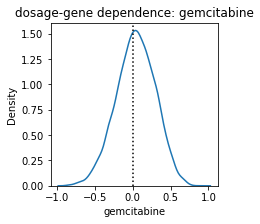

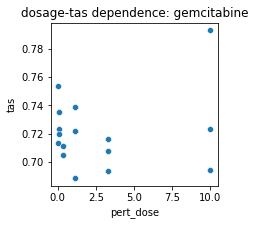

norm_stat    0.0121755
norm_p       0.0971459
drug_res            S+
Name: gemcitabine, dtype: object


In [641]:
for d in norm_dvg_corr_res[norm_dvg_corr_res['drug_res'] == 'S+'].index:
    dose_tas(drug_name=d,
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)
    print(norm_dvg_corr_res.loc[d, :])

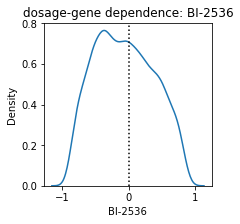

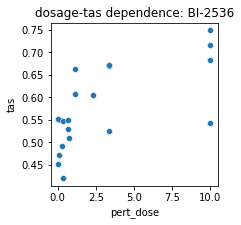

norm_stat      0.0526298
norm_p       6.21767e-25
drug_res               S
Name: BI-2536, dtype: object


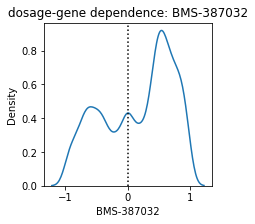

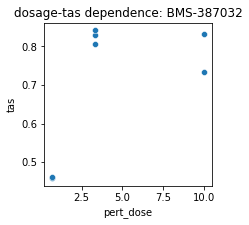

norm_stat        0.158006
norm_p       2.60538e-222
drug_res                S
Name: BMS-387032, dtype: object


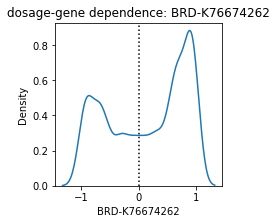

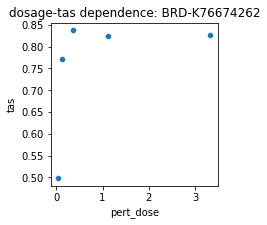

norm_stat        0.169096
norm_p       9.89065e-255
drug_res                S
Name: BRD-K76674262, dtype: object


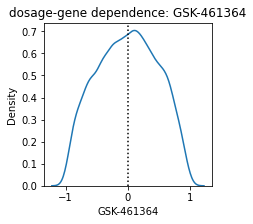

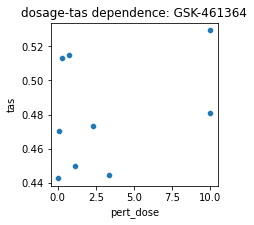

norm_stat      0.0394328
norm_p       3.49997e-14
drug_res               S
Name: GSK-461364, dtype: object


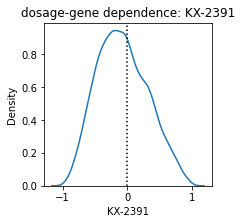

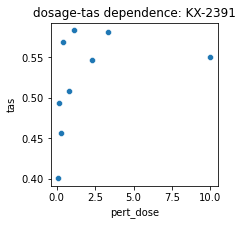

norm_stat      0.0414408
norm_p       1.29386e-15
drug_res               S
Name: KX-2391, dtype: object


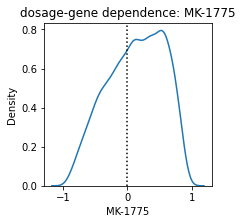

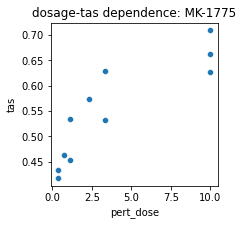

norm_stat        0.05644
norm_p       1.30396e-28
drug_res               S
Name: MK-1775, dtype: object


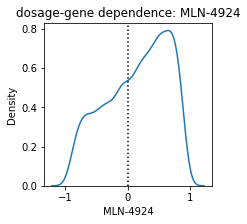

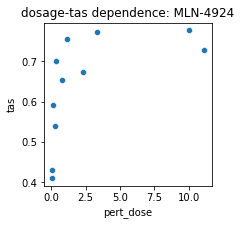

norm_stat      0.0790788
norm_p       8.71681e-56
drug_res               S
Name: MLN-4924, dtype: object


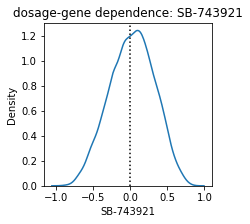

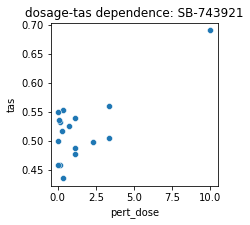

norm_stat      0.0194217
norm_p       0.000916585
drug_res               S
Name: SB-743921, dtype: object


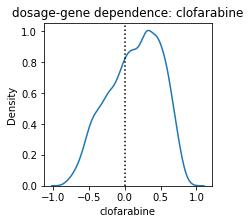

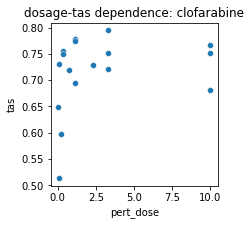

norm_stat     0.0554852
norm_p       1.1513e-27
drug_res              S
Name: clofarabine, dtype: object


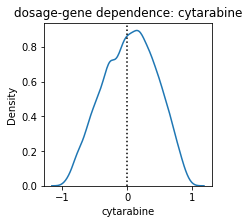

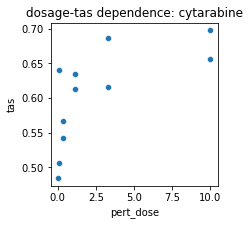

norm_stat      0.0278354
norm_p       2.79001e-07
drug_res               S
Name: cytarabine, dtype: object


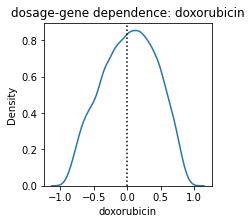

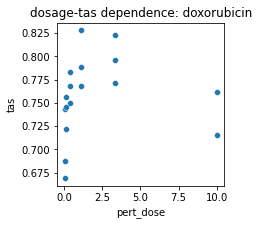

norm_stat      0.0342608
norm_p       8.23633e-11
drug_res               S
Name: doxorubicin, dtype: object


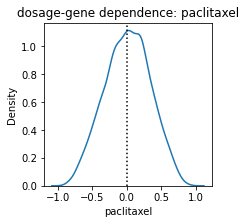

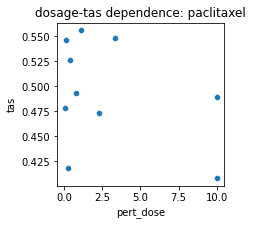

norm_stat       0.023308
norm_p       3.11165e-05
drug_res               S
Name: paclitaxel, dtype: object


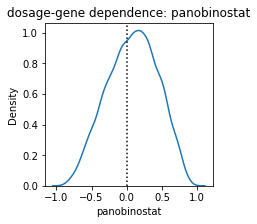

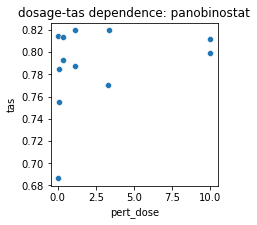

norm_stat      0.0281392
norm_p       1.97034e-07
drug_res               S
Name: panobinostat, dtype: object


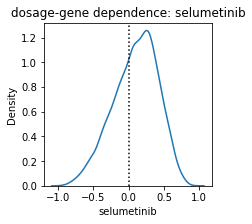

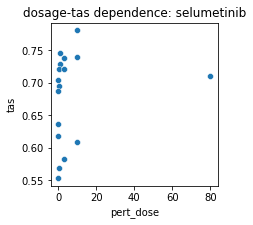

norm_stat      0.0432187
norm_p       5.96661e-17
drug_res               S
Name: selumetinib, dtype: object


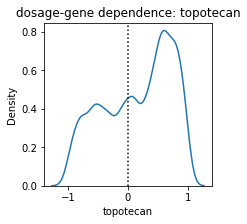

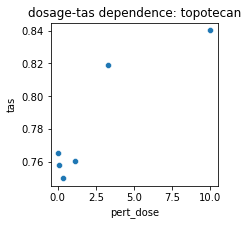

norm_stat        0.123576
norm_p       8.09782e-136
drug_res                S
Name: topotecan, dtype: object


In [642]:
for d in norm_dvg_corr_res[norm_dvg_corr_res['drug_res'] == 'S'].index:
    dose_tas(drug_name=d,
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)
    print(norm_dvg_corr_res.loc[d, :])

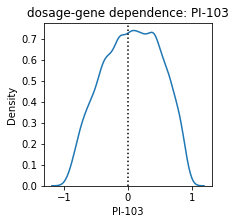

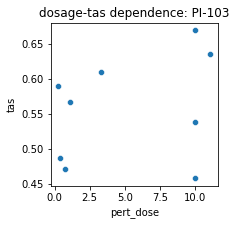

norm_stat      0.0499472
norm_p       1.70241e-22
drug_res              R+
Name: PI-103, dtype: object


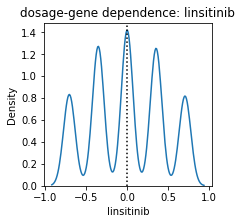

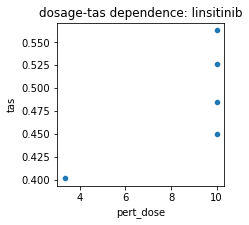

norm_stat        0.157197
norm_p       4.96009e-220
drug_res               R+
Name: linsitinib, dtype: object


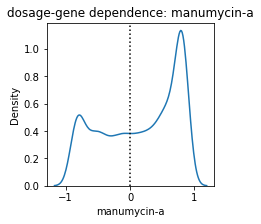

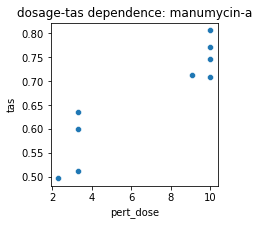

norm_stat        0.131073
norm_p       7.49032e-153
drug_res               R+
Name: manumycin-a, dtype: object


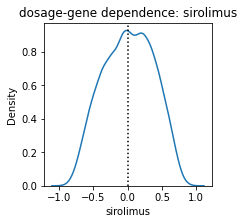

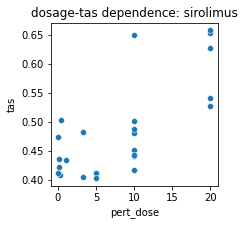

norm_stat      0.0362704
norm_p       4.59092e-12
drug_res              R+
Name: sirolimus, dtype: object


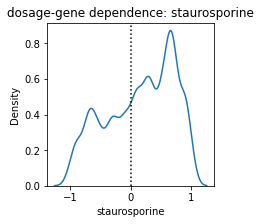

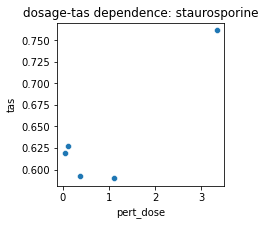

norm_stat           0.116
norm_p       1.00024e-119
drug_res               R+
Name: staurosporine, dtype: object


In [643]:
for d in norm_dvg_corr_res[norm_dvg_corr_res['drug_res'] == 'R+'].index:
    dose_tas(drug_name=d,
         dosage_dependence=dosage_gene_corr,
         sig_info=skcm_sig_24)
    print(norm_dvg_corr_res.loc[d, :])

In [644]:
norm_dvg_corr_res.loc['bortezomib', :]

norm_stat      0.0767889
norm_p       1.26932e-52
drug_res               R
Name: bortezomib, dtype: object

<AxesSubplot:xlabel='drug_res', ylabel='norm_stat'>

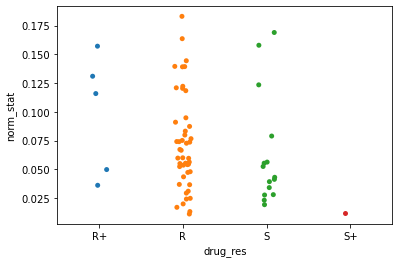

In [645]:
sns.stripplot(x='drug_res', y='norm_stat', order=['R+', 'R', 'S', 'S+'], data=norm_dvg_corr_res)

In [647]:
norm_dvg_corr_res['-log10P'] = -np.log10(norm_dvg_corr_res['norm_p'].astype(float))

<ipython-input-647-e1b30c31013b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_dvg_corr_res['-log10P'] = -np.log10(norm_dvg_corr_res['norm_p'].astype(float))


<AxesSubplot:xlabel='drug_res', ylabel='-log10P'>

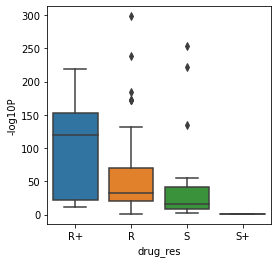

In [658]:
plt.figure(figsize=(4, 4))
sns.boxplot(x='drug_res', y='-log10P', order=['R+', 'R', 'S', 'S+'], data=norm_dvg_corr_res)

In [650]:
norm_dvg_corr_res.loc['vorinostat', :]

norm_stat      0.0911249
norm_p       5.75221e-74
drug_res               R
-log10P          73.2402
Name: vorinostat, dtype: object

In [667]:
# add dosage dependence shift
norm_dvg_corr_res['dose_d_shift'] = synergy_score['shift_ability']

<ipython-input-667-58e297bca33c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_dvg_corr_res['dose_d_shift'] = synergy_score['shift_ability']


In [683]:
# add exact auc
ctrp_auc_renamed = ctrp_res.set_index('cmap_name').groupby(level=0).mean()
ctrp_auc_renamed

,NREC_profile,REC_profile,shift_ability,dose,time,CTRP_ID,CTRP_auc_v21,tas
cmap_name,,,,,,,,
1B,-0.264369,-0.088652,-0.175717,3.702500,24.00000,62111,14.815,0.467159
3-Cl-AHPC,-0.337184,0.132757,-0.469941,3.702500,24.00000,660796,12.328,0.695986
7b-cis,-0.374151,0.282704,-0.656855,8.332500,19.50000,411805,14.433,0.581369
AVA,-0.337412,0.267742,-0.605153,10.000000,24.00000,411856,14.530,0.417082
AZD-4547,-0.306987,0.056471,-0.363458,10.000000,24.00000,660325,12.530,0.494803
...,...,...,...,...,...,...,...,...
tubastatin-a,-0.325257,0.402934,-0.728191,10.000000,15.00000,411749,14.867,0.473396
valdecoxib,-0.212172,0.279661,-0.491832,200.000000,24.00000,32372,14.197,0.423383
vandetanib,-0.296426,0.233476,-0.529902,10.000000,24.00000,349002,13.457,0.495011


In [684]:
norm_dvg_corr_res['CTRP_auc'] = ctrp_auc_renamed['CTRP_auc_v21']

<ipython-input-684-ce226f004120>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_dvg_corr_res['CTRP_auc'] = ctrp_auc_renamed['CTRP_auc_v21']


<AxesSubplot:xlabel='dose_d_shift', ylabel='-log10P'>

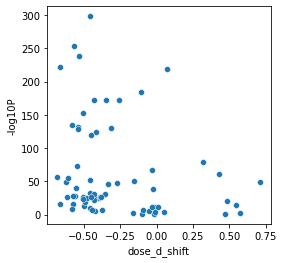

In [685]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='dose_d_shift', y='-log10P', data=norm_dvg_corr_res)

<AxesSubplot:xlabel='CTRP_auc', ylabel='-log10P'>

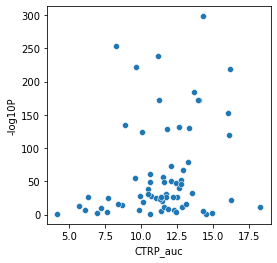

In [686]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='CTRP_auc', y='-log10P', data=norm_dvg_corr_res)

<AxesSubplot:xlabel='dose_d_shift', ylabel='CTRP_auc'>

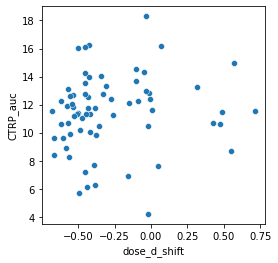

In [671]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='dose_d_shift', y='CTRP_auc', data=norm_dvg_corr_res)

In [679]:
norm_dvg_corr_res['moa'] = compound_info['moa']

<ipython-input-679-bfdb6606e1ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_dvg_corr_res['moa'] = compound_info['moa']


In [680]:
norm_dvg_corr_res.sort_values(by='dose_d_shift', ascending=True)[:10]

,norm_stat,norm_p,drug_res,-log10P,dose_d_shift,CTRP_auc,moa
cmap_name,,,,,,,
NVP-TAE684,0.0799611,5.037e-57,R,56.297828,-0.680104,11.5230,ALK inhibitor
BMS-387032,0.158006,2.60538e-222,S,221.584128,-0.664442,9.6420,CDK inhibitor
selumetinib,0.0432187,5.96661e-17,S,16.224273,-0.664366,8.3986,MEK inhibitor
GDC-0879,0.0742978,2.74634e-49,R,48.561246,-0.618466,10.6120,RAF inhibitor
entinostat,0.054244,1.84807e-26,R,25.733282,-0.615321,12.2520,HDAC inhibitor
MLN-4924,0.0790788,8.71681e-56,S,55.059643,-0.606835,9.5892,NaN
topotecan,0.123576,8.09782e-136,S,135.091632,-0.582896,8.8817,Topoisomerase inhibitor
dasatinib,0.0311443,5.23278e-09,R,8.281267,-0.579682,11.9120,KIT inhibitor
SN-38,0.0564605,1.24377e-28,R,27.905261,-0.572975,10.6950,Topoisomerase inhibitor


In [681]:
norm_dvg_corr.loc['PF-03758309', :]

norm_stat      0.0683372
norm_p       9.34398e-42
drug_res             NaN
Name: PF-03758309, dtype: object

In [687]:
norm_dvg_corr_res['ave_tas'] = ctrp_auc_renamed['tas']

<ipython-input-687-493cf70e8d5b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_dvg_corr_res['ave_tas'] = ctrp_auc_renamed['tas']


<AxesSubplot:xlabel='drug_res', ylabel='ave_tas'>

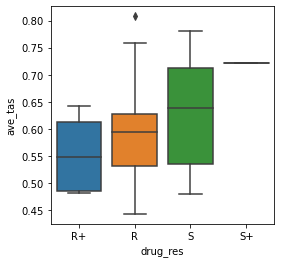

In [688]:
plt.figure(figsize=(4, 4))
sns.boxplot(x='drug_res', y='ave_tas', order=['R+', 'R', 'S', 'S+'], data=norm_dvg_corr_res)

<AxesSubplot:xlabel='drug_res', ylabel='-log10P'>

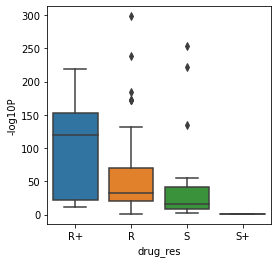

In [689]:
plt.figure(figsize=(4, 4))
sns.boxplot(x='drug_res', y='-log10P', order=['R+', 'R', 'S', 'S+'], data=norm_dvg_corr_res)

<AxesSubplot:xlabel='drug_res', ylabel='dose_d_shift'>

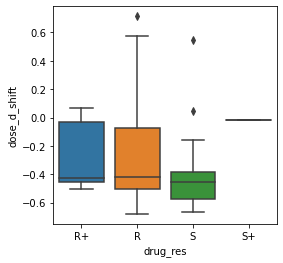

In [690]:
plt.figure(figsize=(4, 4))
sns.boxplot(x='drug_res', y='dose_d_shift', order=['R+', 'R', 'S', 'S+'], data=norm_dvg_corr_res)

# Dosage dependence incorporated with shift ability

## 1. GSEA on these genes

In [309]:
# creat rank list
def pre_rank_initialize(path, matrix):
    # make pre-rank folders
    if path not in os.listdir(data_home + '/dosage/'):
        os.mkdir(data_home + '/dosage/' + path)

    for p in matrix.columns:
        tmp = df(matrix[p]).sort_values(by=p, ascending=False)
        tmp.to_csv(data_home + '/dosage/' + path + '/' + p + '.rnk', header=None, sep='\t')
    
    return

In [310]:
pre_rank_initialize(path='dose_corr_rnk', matrix=dosage_gene_corr)

In [311]:
def pre_rank_selected(gene_set_name, gene_set_path, sig_matrix, save_path):
    prerank_nes = df(columns=sig_matrix.columns)
    prerank_fdr = df(columns=sig_matrix.columns)
    prerank_es = df(columns=sig_matrix.columns)

    for p in sig_matrix.columns:
        rnk = pd.read_csv(data_home + '/dosage/dose_corr_rnk/' + p + '.rnk', header=None, sep="\t")
        pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/' + gene_set_path,
                             processes=1,
                             permutation_num=1000, # reduce number to speed up testing
                             outdir=None, format='png', seed=0, min_size=0, max_size=10000)
        prerank_nes[p] = pre_res.res2d['nes']
        prerank_fdr[p] = pre_res.res2d['fdr']
        prerank_es[p] = pre_res.res2d['es']


    prerank_es.to_csv(data_home + '/dosage/' + save_path + '/' + gene_set_name + '_es.csv', sep=',')
    prerank_nes.to_csv(data_home + '/dosage/' + save_path + '/' + gene_set_name + '_nes.csv', sep=',')
    prerank_fdr.to_csv(data_home + '/dosage/' + save_path + '/' + gene_set_name + '_fdr.csv', sep=',')
    
    return prerank_nes, prerank_fdr, prerank_es

In [312]:
immune_nes, immune_fdr, immune_es = pre_rank_selected(gene_set_name='immune',
                                                      gene_set_path='WolfEtAl_71_Symbols.gmt',
                                                      sig_matrix=dosage_gene_corr,
                                                      save_path='immune_response')

2022-03-18 21:43:17,492 Input gene rankings contains NA values(gene name and ranking value), drop them all!
/home/dyang-server/anaconda3/lib/python3.8/site-packages/gseapy/algorithm.py:73: RuntimeWarning: divide by zero encountered in true_divide
  norm_tag =  1.0/sum_correl_tag
/home/dyang-server/anaconda3/lib/python3.8/site-packages/gseapy/algorithm.py:76: RuntimeWarning: invalid value encountered in multiply
  RES = np.cumsum(tag_indicator * correl_vector * norm_tag - no_tag_indicator * norm_no_tag, axis=axis)
2022-03-18 21:43:39,019 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 21:44:04,018 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 21:44:24,689 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 21:44:46,418 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 21:45:08,151 Input gene rankings conta

2022-03-18 22:31:22,921 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:32:05,598 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:32:48,289 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:33:52,628 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:34:13,935 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:34:35,112 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:35:17,424 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:35:59,729 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:36:20,871 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:36:42,006 Inpu

In [313]:
synergy_nes, synergy_fdr, synergy_es = pre_rank_selected(gene_set_name='synergy',
                                                         gene_set_path='NREC_REC_91061.gmt',
                                                         sig_matrix=dosage_gene_corr,
                                                         save_path='shift_assessment')

2022-03-18 22:51:38,634 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:51:39,502 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:51:40,373 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:51:41,234 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:51:42,118 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:51:43,004 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:51:46,450 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:51:48,162 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:51:49,940 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:51:50,824 Inpu

2022-03-18 22:53:44,844 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:53:45,745 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:53:46,641 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:53:48,444 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:53:50,240 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:53:51,146 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:53:52,046 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:53:53,852 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:53:55,652 Input gene rankings contains NA values(gene name and ranking value), drop them all!
2022-03-18 22:53:59,223 Inpu

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


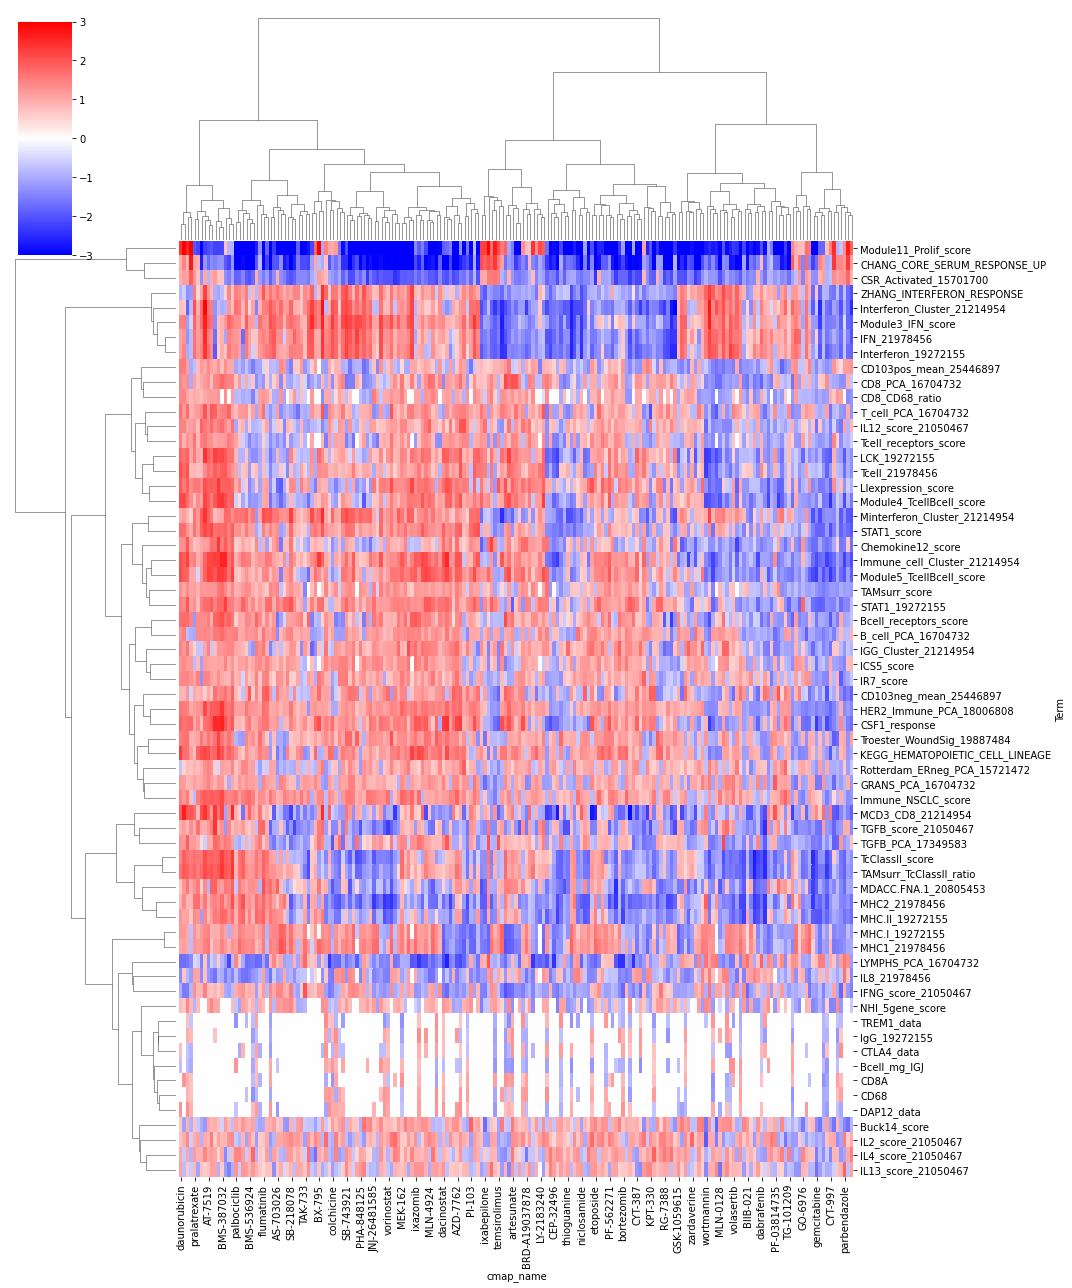

In [358]:
sns.clustermap(immune_nes.dropna(axis=0, how='all').fillna(0),
               figsize=(15, 18),
               vmin=-3, vmax=3,
               method='ward', cmap='bwr')

In [335]:
immune_nes['PF-03758309'].dropna(axis=0, how='any').sort_values()

Term
Module11_Prolif_score             -4.744074
CHANG_CORE_SERUM_RESPONSE_UP      -3.249673
CSR_Activated_15701700            -2.110848
MHC2_21978456                     -1.869426
Tcell_receptors_score             -1.580666
TcClassII_score                   -1.462746
TAMsurr_TcClassII_ratio           -1.450283
CD103pos_mean_25446897            -1.391385
TGFB_score_21050467               -1.356336
IL8_21978456                      -1.329320
T_cell_PCA_16704732               -1.152375
NHI_5gene_score                   -1.084162
IL13_score_21050467               -0.946226
LYMPHS_PCA_16704732               -0.942151
IL4_score_21050467                -0.926789
IFNG_score_21050467               -0.908437
MHC.II_19272155                   -0.881896
IL2_score_21050467                -0.832446
Interferon_Cluster_21214954       -0.797604
MDACC.FNA.1_20805453              -0.638025
Chemokine12_score                 -0.620687
Minterferon_Cluster_21214954      -0.565778
TAMsurr_score              

In [338]:
immune_es['PF-03758309'].dropna(axis=0, how='any').sort_values()[-20:]

Term
Tcell_21978456                  0.288493
Module3_IFN_score               0.299817
CD103neg_mean_25446897          0.308082
TGFB_PCA_17349583               0.352924
Rotterdam_ERneg_PCA_15721472    0.355922
Immune_NSCLC_score              0.363496
Buck14_score                    0.409304
STAT1_19272155                  0.426110
Bcell_receptors_score           0.449893
IGG_Cluster_21214954            0.490294
CTLA4_data                      0.518923
IR7_score                       0.589752
IgG_19272155                    0.641404
CD8A                            0.682493
CD8_CD68_ratio                  0.682560
DAP12_data                      0.711098
MHC.I_19272155                  0.823795
MHC1_21978456                   0.823876
CD68                            0.845867
ICS5_score                      0.860781
Name: PF-03758309, dtype: float64

In [342]:
immune_fdr['PF-03758309'].dropna(axis=0, how='any').sort_values()[:20]

Term
CHANG_CORE_SERUM_RESPONSE_UP    0.000000
Module11_Prolif_score           0.000000
CSR_Activated_15701700          0.001788
MHC2_21978456                   0.024477
Tcell_receptors_score           0.142970
TAMsurr_TcClassII_ratio         0.220529
TcClassII_score                 0.240072
CD103pos_mean_25446897          0.253819
TGFB_score_21050467             0.270324
IL8_21978456                    0.277491
T_cell_PCA_16704732             0.529037
NHI_5gene_score                 0.625775
IGG_Cluster_21214954            0.798791
ICS5_score                      0.806175
Troester_WoundSig_19887484      0.807190
Immune_cell_Cluster_21214954    0.813527
MHC.I_19272155                  0.815951
IR7_score                       0.820893
Bcell_receptors_score           0.828225
IFNG_score_21050467             0.842349
Name: PF-03758309, dtype: float64

In [343]:
immune_es.to_csv(data_home + '/dosage/immune_es_with_dosage_24h_A375.csv', sep=',')

In [329]:
synergy_score = synergy_es.T
synergy_score['shift_ability'] = synergy_score['NREC_profile'] - synergy_score['REC_profile']
synergy_score['moa'] = compound_info['moa']
synergy_score['target'] = compound_info['target']
synergy_score = synergy_score.sort_values(by='shift_ability')

In [378]:
synergy_score[:50]

Term,NREC_profile,REC_profile,shift_ability,moa,target
cmap_name,,,,,
NVP-TAE684,-0.332334,0.347771,-0.680104,ALK inhibitor,ALK
BMS-387032,-0.272410,0.392032,-0.664442,CDK inhibitor,CDK2
selumetinib,-0.368684,0.295683,-0.664366,MEK inhibitor,MAP2K1
AT-7519,-0.295470,0.354082,-0.649552,CDK inhibitor,CDK2
pyrimethamine,-0.316597,0.318376,-0.634973,NaN,NaN
PF-03758309,-0.336656,0.286184,-0.622840,P21 activated kinase inhibitor,PAK4
GDC-0879,-0.317291,0.301174,-0.618466,RAF inhibitor,BRAF
flumatinib,-0.264417,0.352113,-0.616530,Abl kinase inhibitor,ABL1
entinostat,-0.290151,0.325170,-0.615321,HDAC inhibitor,HDAC1


In [400]:
synergy_score.loc['palbociclib', :]

Term
NREC_profile         -0.286868
REC_profile           0.190079
shift_ability        -0.476948
moa              CDK inhibitor
target                    CDK4
Name: palbociclib, dtype: object

In [382]:
synergy_score[-20:]

Term,NREC_profile,REC_profile,shift_ability,moa,target
cmap_name,,,,,
indirubin,0.179544,-0.190333,0.369878,CDK inhibitor,CDK5
ixabepilone,0.198577,-0.175803,0.374380,Microtubule stabilizing agent,TUBB3
tivantinib,0.189405,-0.213794,0.403199,Tyrosine kinase inhibitor,MET
everolimus,0.210344,-0.194105,0.404449,MTOR inhibitor,MTOR
parbendazole,0.214105,-0.213373,0.427478,Tubulin inhibitor,TUBB
LY-2090314,0.199107,-0.239550,0.438657,NaN,NaN
indibulin,0.249586,-0.208557,0.458143,NaN,NaN
MG-132,0.203287,-0.266166,0.469453,Proteasome inhibitor,PSMB1
SNX-2112,0.206120,-0.264408,0.470528,NaN,NaN


In [331]:
synergy_score.to_csv(data_home + '/dosage/shift_with_dosage_24h_A375.csv', sep=',')

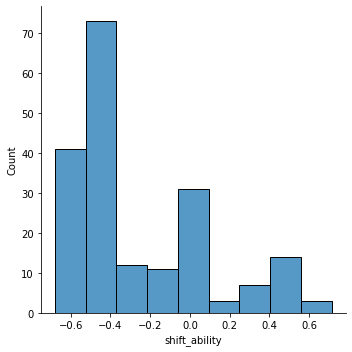

In [373]:
sns.displot(synergy_score['shift_ability'])

# Dosage of PF-03758309

In [415]:
sig_all = pd.read_csv(data_home + '/CMAP2020/siginfo_beta.txt', header=0, index_col=0, sep='\t')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [416]:
sig_PF = sig_all[sig_all['cmap_name'] == 'PF-03758309']

In [417]:
sig_PF.shape

(303, 36)

In [424]:
sig_PF['pert_time'].value_counts()

24.0    303
Name: pert_time, dtype: int64

In [418]:
sig_PF['cell_mfc_name'].value_counts()

PC3         21
A375        20
HELA        18
HT29        18
YAPC        18
HA1E        18
MCF7        17
MCF10A      17
HEK293      16
A549        15
JURKAT      12
HUVEC.A     11
THP1        11
MDAMB231    10
ASC.C        6
CD34         6
NPC.CAS9     6
NEU          6
HME1         6
HCC515       6
SKL.C        6
HUVEC        6
ASC          6
SHSY5Y       6
SKL          6
NPC.TAK      5
NPC          5
HEPG2        5
Name: cell_mfc_name, dtype: int64

In [420]:
sig_PF['pert_idose'].value_counts()

3.33 uM     43
1.11 uM     43
0.04 uM     41
0.37 uM     41
10 uM       31
0.12 uM     27
0.125 uM    14
0.74 uM     11
0.08 uM     11
0.03 uM     11
0.25 uM     11
0.01 uM     11
2.22 uM      8
Name: pert_idose, dtype: int64

<AxesSubplot:xlabel='pert_dose', ylabel='tas'>

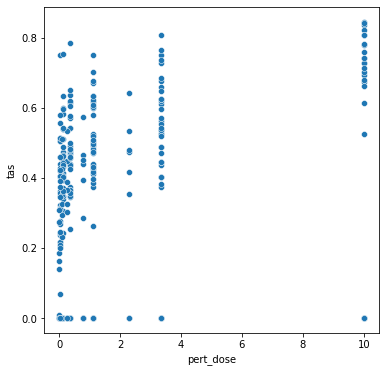

In [422]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='pert_dose', y='tas', data=sig_PF)